# 트랜스포머를 이용한 번역기

## 순서
1. 데이터 다운로드
2. 데이터 정제 및 토큰화
3. 트랜스포머 모델 설계
4. 훈련하기
   - 트랜스포머 선언(하이퍼파라미터 설정)
   - Learning rate, Optimizer
   - Loss function
   - Train step
5. 번역 생성과 어텐션 시각화

## 10. 프로젝트: 더 멋진 번역기 만들기
### Step 1. 데이터 다운로드 
아래 링크에서 korean-english-park.train.tar.gz 를 다운로드받아 한영 병렬 데이터를 확보합니다.

- [jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)
💡이전 [ Seq2seq으로 번역기 만들기 ] 코스에서 사용한 데이터와 동일한 데이터입니다!

터미널을 열어서 하단의 명령어를 입력해주시면 됩니다.

```python
$ mkdir -p ~/aiffel/transformer/data
$ cd ~/aiffel/transformer/data

$ wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
$ gzip -d korean-english-park.train.tar.gz
$ tar -xvf korean-english-park.train.tar
```

## Step 2. 데이터 정제 및 토큰화
1) ```set``` 데이터형이 __중복을 허용하지 않는다는 것을 활용__해 중복된 데이터를 제거하도록 합니다. 데이터의 __병렬 쌍이 흐트러지지 않게 주의__하세요! 중복을 제거한 데이터를 ```cleaned_corpus``` 에 저장합니다.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'  # 그래프를 높은 해상도로 출력
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import sentencepiece as spm


import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.4.1


In [3]:
data_dir = os.getenv('HOME')+'/aiffel/sp_tokenizer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)  # 94123

    cleaned_corpus = list(set(zip(kor, eng)))
    
    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [4]:
print(len(cleaned_corpus))

78968


In [5]:
print(cleaned_corpus[:3])

[('지난 2004년 챔피언십에서 우승했던 즈보나레바는 “윌리엄스는 공격적이었다”며 “2세트와 3세트에서 윌리엄스는 경기를 지휘해 나갔다”고 밝혔다.', '"She stayed aggressive," said Zvonareva, who last qualified for the championships in 2004. "In the second and third, she was dictating."'), ('원문 & 독해설명 인쇄', 'The next special session is to open in April.'), ('그는 “미얀마 분쟁 조절을 위한 대화에 임하는 군의 성실성에 의문이 생긴다”고 말했다.', '"It raises questions about the sincerity of the military in pursuing what we will consider to be a genuine dialogue leading to national reconciliation.')]


2) 정제 함수를 아래 조건을 만족하게 정의하세요.

>- 조건
>
>  - 모든 입력을 소문자로 변환합니다.
>  - 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
>  - 문장부호 양옆에 공백을 추가합니다.
>  - 문장 앞뒤의 불필요한 공백을 제거합니다.

In [6]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()  # 소문자로 변환
    sentence = re.sub(r"[^a-zA-Z?.!,0-9^ㄱ-ㅎㅏ-ㅣ가-힣]+", " ", sentence)  # 알파벳, 문장부호, 한글만 남기고 모두 제거
    sentence = re.sub(r"([?.!,])", r" \1", sentence )  # 문장부호 양옆에 공백을 추가
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()   # 문장 앞뒤의 불필요한 공백을 제거
    
    return sentence

3) 한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, __정제하여 토큰화__ 를 진행합니다! 토큰화에는 __Sentencepiece를 활용__ 하세요. 첨부된 공식 사이트를 참고해 아래 조건을 만족하는 ```generate_tokenizer()``` 함수를 정의합니다. 최종적으로 ```ko_tokenizer``` 과 ```en_tokenizer``` 를 얻으세요. ```en_tokenizer```에는 ```set_encode_extra_options("bos:eos")``` 함수를 실행해 __타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함__ 할 수 있게 합니다.

>- 조건
>
>- 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)
>- 학습 후 저장된 model 파일을 ```SentencePieceProcessor()``` 클래스에 ```Load()```한 후 반환합니다.
?- 특수 토큰의 인덱스를 아래와 동일하게 지정합니다.
```<PAD>``` : 0 / ```<BOS>``` : 1 / ```<EOS>``` : 2 / ```<UNK>``` : 3

- 참고: [google/sentencepiece](https://github.com/google/sentencepiece)

In [7]:
eng_corpus = []
kor_corpus = []

for i in range(len(cleaned_corpus)):
    kor_corpus.append(preprocess_sentence(cleaned_corpus[i][0]))
    eng_corpus.append(preprocess_sentence(cleaned_corpus[i][1]))


In [8]:
print(len(kor_corpus))
print(len(eng_corpus))

78968
78968


In [9]:
print(kor_corpus[:2])

['지난 2004년 챔피언십에서 우승했던 즈보나레바는 윌리엄스는 공격적이었다 며 2세트와 3세트에서 윌리엄스는 경기를 지휘해 나갔다 고 밝혔다 .', '원문 독해설명 인쇄']


In [10]:
print(eng_corpus[:2])

['she stayed aggressive , said zvonareva , who last qualified for the championships in 2004 . in the second and third , she was dictating .', 'the next special session is to open in april .']


In [11]:
def generate_tokenizer(corpus,
                       vocab_size,
                       lang,
                       pad_id=0,
                       bos_id=1,
                       eos_id=2,
                       unk_id=3):
    file = "./%s_corpus.txt" % lang
    model = "%s_spm" % lang

    with open(file, 'w') as f:
        for row in corpus: f.write(str(row) + '\n')

    import sentencepiece as spm
    # sentencepiece 모델 학습
    spm.SentencePieceTrainer.Train(
        '--input=./%s --model_prefix=%s --vocab_size=%d'\
        % (file, model, vocab_size) + \
        '--pad_id==%d --bos_id=%d --eos_id=%d --unk_id=%d'\
        % (pad_id, bos_id, eos_id, unk_id)
    )
    # 모델 불러오기
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load('%s.model' % model)

    return tokenizer

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, lang="ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, lang="en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

4) 토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고, 텐서 enc_train 과 dec_train 으로 변환하세요! (❗모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다.)

In [12]:
from tqdm import tqdm_notebook    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm_notebook(range(len(kor_corpus))):
    src_tokens = ko_tokenizer.encode_as_ids(kor_corpus[idx])  # 문자열을 ids로 토크나이즈 
    tgt_tokens = en_tokenizer.encode_as_ids(eng_corpus[idx])
    
    if (len(src_tokens) > 50): continue    
    if (len(tgt_tokens) > 50): continue
    src_corpus.append(src_tokens)
    tgt_corpus.append(tgt_tokens)


print(len(src_corpus))
print(len(tgt_corpus))
    

/home/aiffel-dj44/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/78968 [00:00<?, ?it/s]

69079
69079


In [13]:
print(src_corpus[:2])

[[54, 862, 34, 5794, 17, 835, 184, 11348, 5, 2248, 5, 227, 12530, 65, 37, 4286, 27, 51, 7412, 2248, 5, 270, 9, 3347, 63, 9432, 26, 31, 0], [624, 613, 619, 580]]


In [14]:
print(tgt_corpus[:2])

[[1, 75, 793, 7, 3510, 6, 18, 15, 7337, 988, 7912, 6, 46, 84, 6941, 7, 20, 4, 2296, 0, 11, 104, 449, 5, 11, 4, 229, 12, 438, 6, 75, 25, 19643, 13, 5, 2], [1, 4, 236, 859, 1348, 24, 9, 307, 11, 808, 110, 5, 2]]


In [15]:
# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

In [16]:
print(len(enc_train), len(dec_train))

69079 69079


In [17]:
print(enc_train.shape)

(69079, 50)


In [18]:
print(dec_train.shape)

(69079, 50)


### Step 3. 모델 설계
오늘 배운 내용을 활용해서 Transformer 모델을 설계해보세요!


### Positional Encoding

![](https://images.velog.io/images/guide333/post/541a9083-c5e3-4eb2-ac2f-ce805dfb63a1/Screenshot%20from%202021-03-04%2011-11-03.png)

순차적으로 단어를 집어 넣는 RNN과 달리 트랜스포머는 한꺼번에 입력 문장을 넣기 때문에 단어의 위치 정보(어순)를 알려주기 위해서 Positional Encoding을 해주어야만 한다. 아래의 그림과 같이 positional encoding과 embedding vector를 각 엘레먼트 별로(element-wise) 더해준다.

![](https://images.velog.io/images/guide333/post/be37636e-6cda-40c5-95dc-bc5bc89c3136/Screenshot%20from%202021-03-04%2011-11-08.png)

트랜스포머는 사인함수와 코사인함수의 값을 임베딩 벡터에 더해주어 단어의 순서 정보를 더해준다. 임베딩 벡터의 각 차원의 인덱스가 짝수인 경우에는 사인함수의 값을, 홀수인 경우에는 코사인 함수의 값을 사용한다. 

![](https://images.velog.io/images/guide333/post/66af2db8-7bdf-4295-bf70-975f6864ba80/Screenshot%20from%202021-03-04%2011-11-17.png)

- $d_{model}$: 임베딩 벡터의 차원
- pos: 입력 문장에서의 임베딩 벡터의 위치
- i: 임베딩 벡터 내의 차원의 인덱스
  
  Q. 최대 문장의 길이가 50, 워드 임베딩 차원을 512로 하는 포지셔널 인코딩 행렬의 모습은 어떻게 되는가? 또한 포지셔널 인코딩 레이어를 사용하여 표현해 보아라. 
  50x512, positional_encoding(50, 512)

In [19]:
# Positional Encoding 구현
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # 인덱스가 짝수
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # 인덱스가 홀수

             
    return sinusoid_table

### Multi-Head Attention

Multi-Head Attention은 여러 개의 서브 모듈을 결합하여 완성된다. 

- class MultiHeadAttention = split_heads() + scaled_dot_product_attention() + combine_heads()

  - split_heads(): Embedding된 입력을 Head 수로 분할    
  - scaled_dot_product_attention(): 분할된 입력으로부터 Attention 값을 구함
  - combine_heads(): 분할된 Head를 다시 하나로 결합
  
- def Masked Multi-Head Attention(): 마스크의 형태를 결정하는 것이 모델 외부의 훈련 데이터기 때문에 MultiHeadAttention 외부에 정의

생성된 마스크를 처리할 수 있도록 scaled_dot_product_attention() 에는 아래 한 줄을 포함한다.

```python
# scaled_qk: Attention을 위한 Softmax 직전의 Scaled QK

if mask is not None: scaled_qk += (mask * -1e9)
```

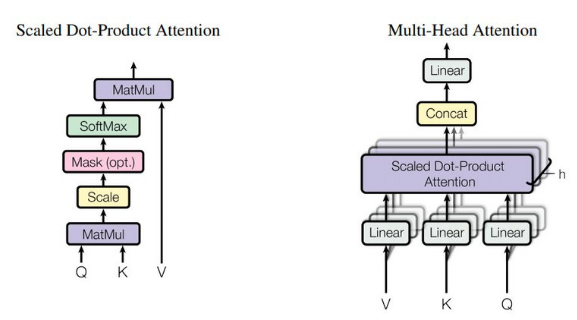    

#### Scaled Dot-Product Attention

  - Q(Query): 디코더의 hidden state
  - K(Key): 인코더의 hidden state
  - attention weight: $softmax(\frac {QK^T}{\sqrt d_k})$ (Q와 K의 유사도를 dot product로 계산)
  - attention weight와 V(value)를 곱함(V는 인코더에서 가져옴)
  
  
- 해당 attention의 input: $d_k$ dimension을 가지는 queries, keys, $d_v$ dimension을 가지는 values
  
  $$Attention(Q, K, V) = softmax(\frac {QK^T}{\sqrt d_k})V$$
  
- Q, K, V는 단어 벡터를 행으로 하는 문장 행렬    

Query가 어떤 단어와 관련되어 있는지 찾기 위해 모든 key들과 연관성을 계산(dot product)한 후, 그 값을 확률값으로 만들어(softmax) 준다. 따라서 query가 어떤 key와 높은 확률로 연관성을 가지는지 알게 된다. 구한 확률값을 value에 곱해서 value에 대해서 scaling한다. 

![](https://images.velog.io/images/guide333/post/1643056d-18d8-4671-bf1d-99a6097317d0/Screenshot%20from%202021-03-04%2012-00-19.png)

- __유사도 행렬__($QK^T$): 각 단어 벡터의 유사도가 모두 기록
- $d_k=d_{model}$/num_heads$


- 행렬의 크기 
1. $d_k$: Q, K 벡터의 크기 -> Q, K 행렬의 크기: (seq\_len, $d_k$), V 행렬의 크기: (seq_len, $d_v$) 
2. $W^Q, W^K$의 크기: ($d_{model}, d_k$), $W^V$의 크기: ($d_{model}, d_v$)(문장행렬과 Q, K, V행렬의 크기로부터 추정)
3. $d_k=d_v=d_{model}$/num\_heads이므로 어텐션 값 행렬 a의 크기는 (seq\_len, $d_v$)이다. 

key와 value는 같은 단어를 의미하나 2개로 나눠 계산하는 이유는 key를 통해 각 단어와의 연관성의 확률을 계산하고 value는 그 확률을 사용해서 attention 값을 계산한다. 


![](https://images.velog.io/images/guide333/post/6141ad25-1edc-4264-ae61-49d2c2fff25f/Screenshot%20from%202021-04-19%2015-16-39.png)

dimension의 루트값으로 나눠주는(rescaling) 이유는 vector가 길어질수록 (dimension이 커질수록) dot-product값이 커지는데, 그 값을 softmax함수에 넣어주면 미분값이 작아진다. back-propagation과정에서 작은 미분값의 의미는 상대적으로 학습이 느려지거나 학습이 잘 안 될 수 있다는 뜻이다. 

-  Scaled Dot-Product Attention은 Dot-Product(=Multiplicative, 곱 연산 기반) Attention을 사용하였고, 차원이 깊어짐에 따라 softmax 값이 작아지는 것을 방지하기 위해 Scale 과정을 포함했다. 

#### Multi-Head Attention

- 이론 설명 

멀티 헤드 어텐션은 한 단어가 여러 차원의 embedding을 가진다면, 일부의 차원들은 각각 다른 정보를 담고 있기 때문에 차원마다 가지고 있는 다른 정보를 여러 개의 Head로 나누어 처리하면 Embedding의 다양한 정보를 캐치할 수 있을 것이라는 아이디어로 시작되었다.

따라서 어텐션을 병렬로 수행한다. 트랜스포머는 입력된 문장 행렬을 num\_heads의 수만큼 쪼개 어텐션을 수행하고 어텐션의 값 행렬 num\_heads개를 하나로 연결(concatenate)한다. 연결된 어텐션 헤드 행렬의 크기는 (seq\_len, $d_{model}$)이다.

![](https://images.velog.io/images/guide333/post/50ac269d-fd1f-4d9c-ac47-3d60626cc077/Screenshot%20from%202021-03-04%2012-07-00.png)

Multi-Head Attention에서 __Head는 주로 8개__ 를 사용한다. Embedding된 10개 단어의 문장이 ```[10, 512]```의 형태를 가진다면, Multi-Head Attention은 이를 ```[10, 8, 64]```로 분할하여 연산한다. __각 64차원의 Embedding을 독립적으로 Attention__ 한 후, 이를 __이어붙여__ 다시금 ```[10, 512]```의 형태로 되돌리며 연산은 끝이 난다.

__병렬로 수행되는 어텐션__ 은 서로 다른 시각에서의 셀프 어텐션 결과를 얻기 때문에 각각 __다른 관점에서의 정보__ 를 얻을 수 있어서 효과가 더 좋다. 
![](https://images.velog.io/images/guide333/post/145034e0-9d28-49b0-931c-41ce470aeb21/Screenshot%20from%202021-03-09%2021-08-10.png)

어텐션 헤드를 모두 연결한 행렬에 가중치 행렬 $W^O$를 곱해 나온 결과 행렬이 멀티 헤드 어텐션의 결과물이며, 이 행렬의 크기는 (seq\_len, $d_{model}$)이다. 

여기서 가중치 행렬을 곱하는 것을 구현 상에서는 입력을 밀집층(Dense layer)를 지나게 하여 구현한다. 

Head로 쪼갠 Embedding들끼리 유사한 특성을 가진다는 보장이 없기 때문에 __앞단에 Linear 레이어를 추가__ 한다. __Linear 레이어는 데이터를 특정 분포로 매핑__ 시키는 역할을 해주기 때문에, 설령 단어들의 분포가 제각각이더라도 Linear 레이어는 Multi-Head Attention이 잘 동작할 수 있는 적합한 공간으로 Embedding을 매핑한다.

마찬가지로 각각의 Head가 Attention 한 값이 균일한 분포를 가질 거란 보장이 없기 때문에 모든 Attention 값을 합쳐준 후, 최종적으로 Linear 레이어를 거치게 된다. 

In [20]:
# Multi Head Attention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads
        
        # Linear Layer
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)   #  Scaled QK

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)   # Attention Weights
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ] - tf.reshape으로 만듬
        """

        bsz = x.shape[0]  # batch size
        # reshape - shape의 한 원소만 -1, 의미는 전체 크기가 일정하게 유지되도록 해당 차원의 길이가 자동으로 계산
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])   #  perm은 치환하는 위치를 알려줌

        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        # Linear 레이어 추가 - embedding 매핑
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

#### Position-wise FFNN 포지션-와이즈 피드 포워드 신경망
포지션 와이즈 FFNN(Fully-connected FFNN)의 수식과 식을 그림으로 표현한 것은 아래와 같다. 

$$FFNN(x) = MAX(0, xW_1+b_1)W_2 + b_2$$

![](https://images.velog.io/images/guide333/post/5fc68984-22cb-4556-9835-9c8d281ee7ae/Screenshot%20from%202021-03-09%2021-31-15.png)

- x: 멀티 헤드 어텐션의 결과로 나온 (seq\_len, $d_{model}$)의 크기를 가지는 행렬
- 가중치 행렬 $W_1$: ($d_{model}, d_{ff}$)의 크기를 가진다.
- 가중치 행렬 $W_2$: ($d_{ff}, d_{model}$)의 크기를 가진다. ($d_{ff}$는 은닉층의 크기)

매개변수 $W_1, b_1, W_2, b_2$은 하나의 인코더 층에서는 동일하나 인코더 층마다는 다른 값을 가진다. 

![](https://images.velog.io/images/guide333/post/5cc9e463-89b1-4e4e-ae9d-22e773682c32/Screenshot%20from%202021-03-09%2021-33-34.png)

d_ff 는 논문의 설명대로라면 2048 일 거고, d_model 은 512. [ batch x length x d_model ] 의 입력을 받아 w_1 이 2048차원으로 매핑하고 활성함수 ReLU를 적용한 후, 다시 w_2 를 통해 512차원으로 되돌리는 과정

예를 들면 10단어로 이루어진 Attention된 문장 [10, 512]를 [10, 2048] 공간으로 매핑, 활성함수를 적용한 후 다시 [10, 512] 공간으로 되돌린다. 

In [21]:
# Position-wise Feed Forward Network 구현
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)

        return out

- 나머지 부분은 텐서플로우 내부에 이미 구현체가 포함되어 있어 사용하기만 하면 된다.

#### Residual connection 잔차 연결, Layer Normalization 층 정규화

![](https://images.velog.io/images/guide333/post/daa47032-4692-44ce-ade1-90f263c86bb0/Screenshot%20from%202021-03-09%2021-35-33.png)

#### 1. 잔차 연결
![](https://images.velog.io/images/guide333/post/380a32c4-dff1-4b41-a4c6-73085fe4fafc/Screenshot%20from%202021-03-09%2021-36-17.png)

함수 $F(x)$는 트랜스포머에서의 서브층을 의미한다. 잔차연결은 서브층의 입력과 출력을 더하는 것이다. 만약 서브층이 멀티 헤드 어텐션이면 잔차 연결 연산은 아래와 같다.  

![](https://images.velog.io/images/guide333/post/0ebdf378-c152-4a47-81f8-6fc071960957/Screenshot%20from%202021-03-09%2021-37-34.png)

#### 2. 층 정규화

Layer Normalization은 데이터를 Feature 차원에서 정규화를 하는 방법이다. 10단어의 Embedding된 문장 ```[10, 512]```에서 512차원 Feature를 정규화하여 분포를 일정하게 맞춰준다. 

$$LN = LayerNorm(x + Sublayer(x))$$ 

층 정규화는 __텐서의 마지막 차원__ 에 대해 평균과 분산을 구한 값으로 정규화하여 학습을 돕는다. 텐서의 마지막 차원은 $d_{model}$ 차원이며, 아래 그림은 $d_{model}$ 차원의 방향을 화살표로 표현하였다. 출력의 크기는 (seq\_len, $d_{model}$)이다. 화살표 방향으로 평균과 분산을 구하고, 정규화를 해준다. 층 정규화를 한 후에 벡터 $x_i$는 $ln_i$라는 벡터로 정규화된다. 

![](https://images.velog.io/images/guide333/post/7a50b2c8-8c78-4287-bfab-3415678cfff1/Screenshot%20from%202021-03-09%2022-27-57.png)

$$ln_i=LayerNorm(x_i)$$

층 정규화는 2가지 과정으로 이루어진다. 

1. 평균과 분산을 통해 벡터 $x_i$를 정규화한다.
$$\hat x_{i,k} = \frac {x_{i,k}-\mu_i}{\sqrt{{\sigma_i}^2 + \epsilon}}$$ 
(여기서 $\epsilon$은 분모가 0이 되는 것을 방지하는 값)

2. 감마와 베타라는 벡터를 준비해 아래와 같이 정규화를 해준다. (감마와 베타의 초기값은 각각 1과 0이다.)
![](https://images.velog.io/images/guide333/post/2fee9051-c08b-406b-9d3e-63eb0cb25e81/Screenshot%20from%202021-03-09%2022-34-18.png)
$$ln_i = \gamma \hat x_i + \beta = LayerNorm(x_i)$$  ($\gamma, \beta$는 학습 가능한 파라미터)

### 디코더에서의 어텐션
디코더에는 두 개의 멀티 헤드 어텐션이 들어간다. 첫번째 서브층은 mask의 인자값으로 look_ahead_mask가 들어가고, 두번째 서브층은 mask의 인자값으로 padding_mask가 들어간다. 

In [22]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, enc_attn

In [23]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.dec_self_attn(out, enc_out, enc_out, causality_mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

### 모듈 조립하기

앞에서 만든 모든 모듈들을 가지고 트랜스포머의 Encoder 한 층과 Decoder 한 층을 각각 완성하면 된다.

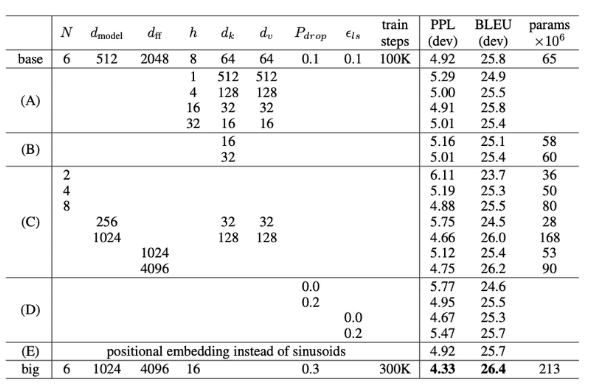

\<Attention Is All You Need> 논문에 포함된 위의 표는 트랜스포머가 얼마나 많은 실험을 통해 탄생한 모델인지 보여준다. 이런 실험이 가능하려면 모델이 동적으로 완성될 수 있게 해야 한다. 즉 레이어를 원하는 만큼 쌓아 실험을 자유롭게 할 수 있게 모델을 완성해야 한다.

그 방법은 EncoderLayer, DecoderLayer를 쓸 수 있게 ```tf.keras.layers.Layer``` 클래스를 상속받아 레이어 클래스로 정의해 주면 된다. 

```python
N = 10

# 10개의 Linear Layer를 한 방에!
linear_layers = [tf.keras.layers.Dense(30) for _ in range(N)]

# 10개의 Encoder Layer도 한 방에!
enc_layers = [TransformerEncoderLayer(30) for _ in range(N)]
```

>Transformer의 구현은 정말 많은데, 그중에서 Normalization Layer의 위치에 대한 논의가 종종 나온다. 실제 논문에서는 [ Input ] - [ Module ] - [ Residual ] - [ Norm ] (Module = MHA, FFN)으로 표현되어 있지만 정작 Official 구현인 구글의 Tensor2Tensor 에서는 [ Input ] - [ Norm ] - [ Module ] - [ Residual ] 방식을 사용했다.           
>경험에 따르면 레이어가 많아질수록 후자가 약간 더 좋은 성능을 보였기에 필자는 논문 대신 Official 구현을 따르길 권장한다!

(참고) 트랜스포머의 Layer Normalization의 위치에 대한 논의를 다룬 [On Layer Normalization in the Transformer Architecture](https://arxiv.org/pdf/2002.04745.pdf)이라는 제목의 논문이 2020년 초반에 발표되었다. 이 논문에서는 모듈 앞에 Normalization Layer를 두는 pre-LN 방식이 왜 유리한지를 설명하고 있다.


### Encoder 레이어 구현하기

In [24]:
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        out = x

        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns

In [25]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]


    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x

        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

### Transformer 완성하기
아래 조건에 맞게 Transformer 클래스를 완성한다.

>조건
>
>1. ```shared``` 변수를 매개변수로 받아 ```True``` 일 경우 __Decoder Embedding과 출력층 Linear의 Weight를 공유__ 할 수 있게 하세요! Weight가 공유될 경우 Embedding 값에 sqrt(d_model)을 곱해줘야 하는 것, 잊지 않으셨죠? (참고: ```tf.keras.layers.Layer.set_weights()```)
2. 정의한 ```positional_encoding``` 의 반환값 형태는 ```[ Length x d_model ]``` 인데, 이를 더해 줄 Embedding 값 형태가 ```[ Batch x Length x d_model ]``` 이라서 연산이 불가능합니다. 연산이 가능하도록 수정하세요! (참고: ```tf.expand_dims()```, ```np.newaxis```)

#### Weight Sharing
모델의 일부 레이어가 동일한 사이즈의 weight를 가질 때 등장하는 테크닉. 하나의 Weight를 두 개 이상의 레이어가 동시에 사용하는 것.  

- 예: 언어 모델의 Embedding 레이어와 최종 Linear 레이어가 동일한 사이즈의 Weight를 가진다. 프로그래밍 개념 중 Call By Reference(참조에 의한 호출: 인자로 받은 값의 주소를 참조하여 직접 값에 영향을 준다.)

Weight Sharing은 튜닝해야 할 파라미터 수가 감소하기 때문에 학습에 더 유리, 자체 Regularization 효과. (유연성이 제한되어 과적합을 피하기 용이)

트랜스포머에서는 __Decoder의 Embedding 레이어와 출력층 Linear 레이어의 Weight를 공유__ 하는 방식을 사용한다. 소스 Embedding과 타겟 Embedding도 논문상에서는 공유했지만 이는 언어의 유사성에 따라서 선택적으로 사용한다. 만일 소스와 타겟 Embedding 층까지 공유한다면 3개의 레이어가 동일한 Weight를 사용한다. 

또한 출력층 Linear 레이어와 Embedding 레이어의 Feature 분포가 다르므로 Embedding 된 값에 d_model의 제곱근 값을 곱해준다. 분포를 맞춰줌과 동시에 Positional Encoding이 Embedding 값에 큰 영향을 미치는 것을 방지한다. 

In [26]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,  # 레이어의 차원수
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
            

        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        # np.newaxis: numpy array의 차원 늘려주기
        
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
            
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

### Masking
#### 1. Padding Masking
 패딩토큰을 이용한 마스킹을 패딩 마스킹이라고 한다. 자연어 처리에서 정해준 길이보다 짧은 문장에 숫자 0을 채워서 문장의 길이를 맞춰주는 전처리 작업을 한다. 여기서 숫자 0은 실제 의미가 있는 단어가 아니므로 어텐션 등과 같은 연산에서 제외하기 위해 패딩 마스킹을 한다.
 
scaled_dot_product_attention() 함수에서 ```logits += (mask * -1e9)```이 패딩 마스킹의 역할을 한다. 즉 어텐션 스코어 행렬의 마스킹 위치에 매우 작은 음수값을 넣어준다. 소프트맥스 함수를 지나면 해당 위치의 값은 0에 가까운 값이 되어 패딩 토큰이 단어 간 유사도를 구하는데 반영되지 않는다. 

![](https://images.velog.io/images/guide333/post/fba8e8fe-b191-4654-b40c-89ae178cc057/Screenshot%20from%202021-03-09%2021-18-27.png)

#### 2. Look-ahead masking(다음 단어 가리기)
룩어헤드 마스킹은 디코더의 셀프 어텐션에서 사용된다. 인코더와 달리 디코더에서는 뒤의 단어를 미리 알게 되면 다음 단어를 예측하는 훈련을 할 수 없기 때문에 자신보다 다음에 나올 단어를 참고하지 않도록 가려준다. 즉 쿼리 단어 뒤에 나오는 키 단어들에 대해서 마스킹하여 이전 단어들과의 유사도만 구하게 한다. 아래의 그림에서 빨간색 부분이 마스킹한 부분이다.
![](https://images.velog.io/images/guide333/post/0d992e3a-da5a-4516-8bcb-498e203ae779/Screenshot%20from%202021-03-09%2022-45-55.png)

룩어헤드 마스크에는 패딩 마스크를 포함하도록 구현한다. 

#### 인과 관계 마스킹(Causality Masking)

트랜스포머는 모든 단어를 병렬적으로 처리하기 때문에 자기 회귀적인 특성을 잃어버렸고, 이는 문장을 생성할 수 없음을 의미한다. 이 자기 회귀적인 특성을 살리기 위해 __인과 관계 마스킹__ 을 추가하였다. 인과 관계 마스킹은 목표하는 문장의 일부를 가려 __인위적으로 연속성을 학습__ 하게 하는 방법이다.

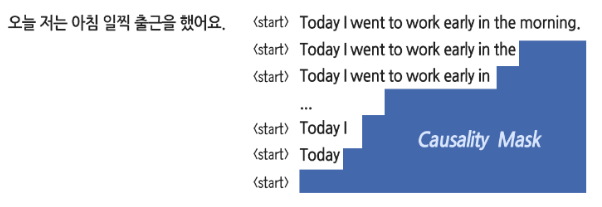

위의 과정을 거치면 __모든 Time-step에 대한 입력을 한 번에 처리__ 하면서 __자기 회귀적인 특성도 유지__ 하게 된다.  테스트 시 소스 문장을 Encoder에 전달하고 타겟 문장을 ```<start>```만 넣어도 모델이 ```<start>``` 토큰만 보고 문장을 생성한 적(위 그림의 마지막 step)이 있기 때문에 첫 번째 단어를 생성할 수 있고 생성된 단어는 입력으로 다시 전달되어 자귀 회귀적으로 문장을 생성한다. 

따라서 인과 관계 마스크는 __대각항을 포함하지 않는 삼각 행렬__ 의 모양을 갖는다. 입력 문장만을 보고 첫 번째 단어를 생성하는 것은 타겟 문장을 모두 가리는 것이 타당하니 대각항을 포함하는 게 맞지만, 그럴 경우 Attention 값을 구하는 과정에서 마지막(혹은 첫 번째) 행이 0개 요소에 대해 Softmax를 취하게 되므로 오류를 야기한다. 따라서 ```<start>``` 토큰을 활용해 마스크가 대각항을 포함하지 않는 형태가 되게 한다. 

In [27]:
# Mask  생성하기
def generate_padding_mask(seq):
    # tf.math.equal: seq의 원소가 0이 되면 true로 반환, 아니면 false 반환
    # tf.cast: true를 float32로 변환
    
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]    # np.newaxis: numpy array의 차원 늘려주기

def generate_causality_mask(src_len, tgt_len):
    # np.cumsum(): 배열에서 행에 따라 누적되는 원소들의 누적합 계산
    # np.eye(): 대각선이 1인 seq_len x seq_len 크기의 대각행렬 생성
    
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)  # tf.cast: mask(텐서)를 float32로 변환


def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

### Step 4. 훈련하기
앞서 필요한 것들을 모두 정의했기 때문에 우리는 훈련만 하면 됩니다! 아래 과정을 차근차근 따라가며 모델을 훈련하고, 예문에 대한 멋진 번역을 제출하세요!

1. 2 Layer를 가지는 Transformer를 선언하세요.
(하이퍼파라미터는 자유롭게 조절합니다.)

In [28]:
n_layers = 2
d_model = 512
n_heads = 8
d_ff = 2048
dropout = 0.3

In [29]:
transformer = Transformer(
    n_layers= n_layers,
    d_model = d_model,
    n_heads=n_heads,
    d_ff=d_ff,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=200,
    dropout=dropout,
    shared_fc=True,
    shared_emb=True)

2. 논문에서 사용한 것과 동일한 Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언하세요. (Optimizer의 파라미터 역시 논문과 동일하게 설정합니다.)

### Learning Rate Schedular
트랜스포머를 훈련할 때 Adam Optimizer를 사용했는데, Learning Rate를 수식에 따라 변화시키며 사용했다. 아래의 수식을 따르면 warmup_steps까지는 lrate가 __선형적으로 증가__하고 이후에는 step_num에 비례해 __점차 감소__한다. 

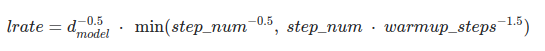

이런 Learning rate를 사용하면 __초반 학습이 잘 되지 않은 상태에서의 학습 효율이 늘어나__ 고, 어느 정도 학습이 된 후에는 __디테일한 튜닝__ 을 통해 Global Minimum을 찾아가는 효과가 나타난다. 학습의 초반과 후반은 warmup-steps 값에 따라 결정된다. 

In [30]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

3. Loss 함수를 정의하세요.         
Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, Masking 되지 않은 입력의 개수로 Scaling하는 과정을 추가합니다. (트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문입니다.)

In [31]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

4. train_step 함수를 정의하세요.
입력 데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 합니다.


In [32]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]  # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

학습을 진행합니다.
매 Epoch 마다 제시된 예문에 대한 번역을 생성하고, 멋진 번역이 생성되면 그때의 하이퍼파라미터와 생성된 번역을 제출하세요!

```python
# 예문
1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

# 결과(output)
Translations
> 1. obama is the president elect .
> 2. they are in the city .
> 3. they don t need to be a lot of drink .
> 4. seven other people have been killed in the attacks .

Hyperparameters
> n_layers: 2
> d_model: 512
> n_heads: 8
> d_ff: 2048
> dropout: 0.3

Training Parameters
> Warmup Steps: 4000
> Batch Size: 64
> Epoch At: 5
```

번역 생성에는 아래 소스를 사용하시길 바랍니다!

In [33]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [34]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [35]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

translate() 함수의 plot_attention 변수를 True 로 주면 번역 결과에 대한 Attention Map을 시각화 해볼 수 있습니다.

💡 이번 프로젝트에서 제시한 예문은 Seq2seq으로 번역기 만들기의 예문과 동일합니다. Seq2seq과 Transformer로 만든 두 번역기의 성능을 하이퍼파라미터를 조정 등 다양한 연구해보시면 학습에 도움이 되실 거예요!

마지막으로, 학습의 전 과정을 구현한 코드를 첨부합니다. 구현과정에 참고해 주세요. 수고하셨습니다!!


```PYTHON
# 예문
1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

# 결과(output)
Translations
> 1. obama is the president elect .
> 2. they are in the city .
> 3. they don t need to be a lot of drink .
> 4. seven other people have been killed in the attacks .

Hyperparameters
> n_layers: 2
> d_model: 512
> n_heads: 8
> d_ff: 2048
> dropout: 0.3

Training Parameters
> Warmup Steps: 4000
> Batch Size: 64
> Epoch At: 5
    
```

In [36]:
# 학습
import warnings
warnings.filterwarnings(action='ignore')

from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

        
    print("Translations")   
    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)
        
    print()
    print("Hyperparameters")
    print("n_layers:", n_layers)
    print("n_heads:", n_heads)
    print("d_ff:", d_ff)
    print("dropout:", dropout)
    print()
    print("Training Parameters")
    print("Warmup steps: 4000")
    print("Batch Size:", BATCH_SIZE)
    print("Epoch At:", epoch+1)

  0%|          | 0/1080 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

  0%|          | 0/1080 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is the first time in the white house .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s city is not to the city s city .
Input: 커피는 필요 없다.
Predicted translation: if you re not a good .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll in the death toll in the death toll .

Hyperparameters
n_layers: 2
n_heads: 8
d_ff: 2048
dropout: 0.3

Training Parameters
Warmup steps: 4000
Batch Size: 64
Epoch At: 2


  0%|          | 0/1080 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city cited the city .
Input: 커피는 필요 없다.
Predicted translation: the need need need need to need to need need to need to need to need to need to need to need to need to need the need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed , killed , killed , killing at least six people .

Hyperparameters
n_layers: 2
n_heads: 8
d_ff: 2048
dropout: 0.3

Training Parameters
Warmup steps: 4000
Batch Size: 64
Epoch At: 3


  0%|          | 0/1080 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is president obama is expected to president obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s city is the city of urban city .
Input: 커피는 필요 없다.
Predicted translation: coffee is needed to need no need coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven death toll from the death toll from the death toll from the death toll .

Hyperparameters
n_layers: 2
n_heads: 8
d_ff: 2048
dropout: 0.3

Training Parameters
Warmup steps: 4000
Batch Size: 64
Epoch At: 4


  0%|          | 0/1080 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the mountain .
Input: 커피는 필요 없다.
Predicted translation: need to be needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed .

Hyperparameters
n_layers: 2
n_heads: 8
d_ff: 2048
dropout: 0.3

Training Parameters
Warmup steps: 4000
Batch Size: 64
Epoch At: 5


  0%|          | 0/1080 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is expected to visit president obama s president is expected to visit the president s president obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is in cities .
Input: 커피는 필요 없다.
Predicted translation: need to need need need no need need need need need need need need need need to need need no need need need for need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in seven other sunni tribal elder .

Hyperparameters
n_layers: 2
n_heads: 8
d_ff: 2048
dropout: 0.3

Training Parameters
Warmup steps: 4000
Batch Size: 64
Epoch At: 6


  0%|          | 0/1080 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: president obama is expected to be president .
Input: 시민들은 도시 속에 산다.
Predicted translation: some people are the cities .
Input: 커피는 필요 없다.
Predicted translation: need need need to need need need need need to need need need need need to need need need need to need need need need need need need need need need to need need need need need need need need need need need need need need need need need need
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven civilian death toll was among the death toll .

Hyperparameters
n_layers: 2
n_heads: 8
d_ff: 2048
dropout: 0.3

Training Parameters
Warmup steps: 4000
Batch Size: 64
Epoch At: 7


  0%|          | 0/1080 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: president is going to be president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is designed .
Input: 커피는 필요 없다.
Predicted translation: don t need you need to need you need to need you need to need need if necessar .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died .

Hyperparameters
n_layers: 2
n_heads: 8
d_ff: 2048
dropout: 0.3

Training Parameters
Warmup steps: 4000
Batch Size: 64
Epoch At: 8


  0%|          | 0/1080 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: president clinton is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is part of the city .
Input: 커피는 필요 없다.
Predicted translation: need to need need to need necessar .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven death tolled in the storm .

Hyperparameters
n_layers: 2
n_heads: 8
d_ff: 2048
dropout: 0.3

Training Parameters
Warmup steps: 4000
Batch Size: 64
Epoch At: 9


  0%|          | 0/1080 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: president barack obama is a time he s gonna president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is part of the city . . . . . . . . . . . . . . . . . . . . . they are the designed streets .
Input: 커피는 필요 없다.
Predicted translation: need to need need if need to need the need to need need to need need to need if need to need to need the need need need need to need need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died .

Hyperparameters
n_layers: 2
n_heads: 8
d_ff: 2048
dropout: 0.3

Training Parameters
Warmup steps: 4000
Batch Size: 64
Epoch At: 10


  0%|          | 0/1080 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: president barack obama is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is not they re doing .
Input: 커피는 필요 없다.
Predicted translation: need to need necessary need to need to need to need to need to need to need to need to need to need to need to need to need to need to need to need to need to necessar .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died .

Hyperparameters
n_layers: 2
n_heads: 8
d_ff: 2048
dropout: 0.3

Training Parameters
Warmup steps: 4000
Batch Size: 64
Epoch At: 11


  0%|          | 0/1080 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: president barack obama is a lost in the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is now in the city . . . . . . . is you re part of the city .
Input: 커피는 필요 없다.
Predicted translation: but need to need you need to need you need to need you need to need it to need to need to need it .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died .

Hyperparameters
n_layers: 2
n_heads: 8
d_ff: 2048
dropout: 0.3

Training Parameters
Warmup steps: 4000
Batch Size: 64
Epoch At: 12


  0%|          | 0/1080 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: president barack obama is alone .
Input: 시민들은 도시 속에 산다.
Predicted translation: at some point , the city in town , you must be praised .
Input: 커피는 필요 없다.
Predicted translation: don t need need to need it .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .

Hyperparameters
n_layers: 2
n_heads: 8
d_ff: 2048
dropout: 0.3

Training Parameters
Warmup steps: 4000
Batch Size: 64
Epoch At: 13


  0%|          | 0/1080 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: president is going to be the president is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s cities in the city is not in the city .
Input: 커피는 필요 없다.
Predicted translation: don need need to do it .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died , the dead .

Hyperparameters
n_layers: 2
n_heads: 8
d_ff: 2048
dropout: 0.3

Training Parameters
Warmup steps: 4000
Batch Size: 64
Epoch At: 14


  0%|          | 0/1080 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: president barack obama is a time .
Input: 시민들은 도시 속에 산다.
Predicted translation: at the city is now .
Input: 커피는 필요 없다.
Predicted translation: need to need the need to coffee need to need the need to do it .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .

Hyperparameters
n_layers: 2
n_heads: 8
d_ff: 2048
dropout: 0.3

Training Parameters
Warmup steps: 4000
Batch Size: 64
Epoch At: 15


  0%|          | 0/1080 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: president barack obama is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is part of the city inway .
Input: 커피는 필요 없다.
Predicted translation: don need need to do need to need need need to do .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people sought the dead .

Hyperparameters
n_layers: 2
n_heads: 8
d_ff: 2048
dropout: 0.3

Training Parameters
Warmup steps: 4000
Batch Size: 64
Epoch At: 16


  0%|          | 0/1080 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: president obama is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: at some of the city is not in the city .
Input: 커피는 필요 없다.
Predicted translation: need to need need need to need need need need to need need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died seven of injuries have died .

Hyperparameters
n_layers: 2
n_heads: 8
d_ff: 2048
dropout: 0.3

Training Parameters
Warmup steps: 4000
Batch Size: 64
Epoch At: 17


  0%|          | 0/1080 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: president barack obama is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: at some urban designed .
Input: 커피는 필요 없다.
Predicted translation: need to need need need to need need need to need need to need need need to need need to need need to need need need need to need need need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a seven death toll were wounded .

Hyperparameters
n_layers: 2
n_heads: 8
d_ff: 2048
dropout: 0.3

Training Parameters
Warmup steps: 4000
Batch Size: 64
Epoch At: 18


  0%|          | 0/1080 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: president clinton is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: some people in the city .
Input: 커피는 필요 없다.
Predicted translation: need to need need need to need need need to need need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven death death toll stood seven people .

Hyperparameters
n_layers: 2
n_heads: 8
d_ff: 2048
dropout: 0.3

Training Parameters
Warmup steps: 4000
Batch Size: 64
Epoch At: 19


  0%|          | 0/1080 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: president obama s main test , he s just back to president , the president , is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the town in the city is not the design of the cities .
Input: 커피는 필요 없다.
Predicted translation: don t need to need short need to need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died .

Hyperparameters
n_layers: 2
n_heads: 8
d_ff: 2048
dropout: 0.3

Training Parameters
Warmup steps: 4000
Batch Size: 64
Epoch At: 20


Input: 오바마는 대통령이다.
Predicted translation: president obama s main test , he s just back to president , the president , is president .
Encoder Layer 1


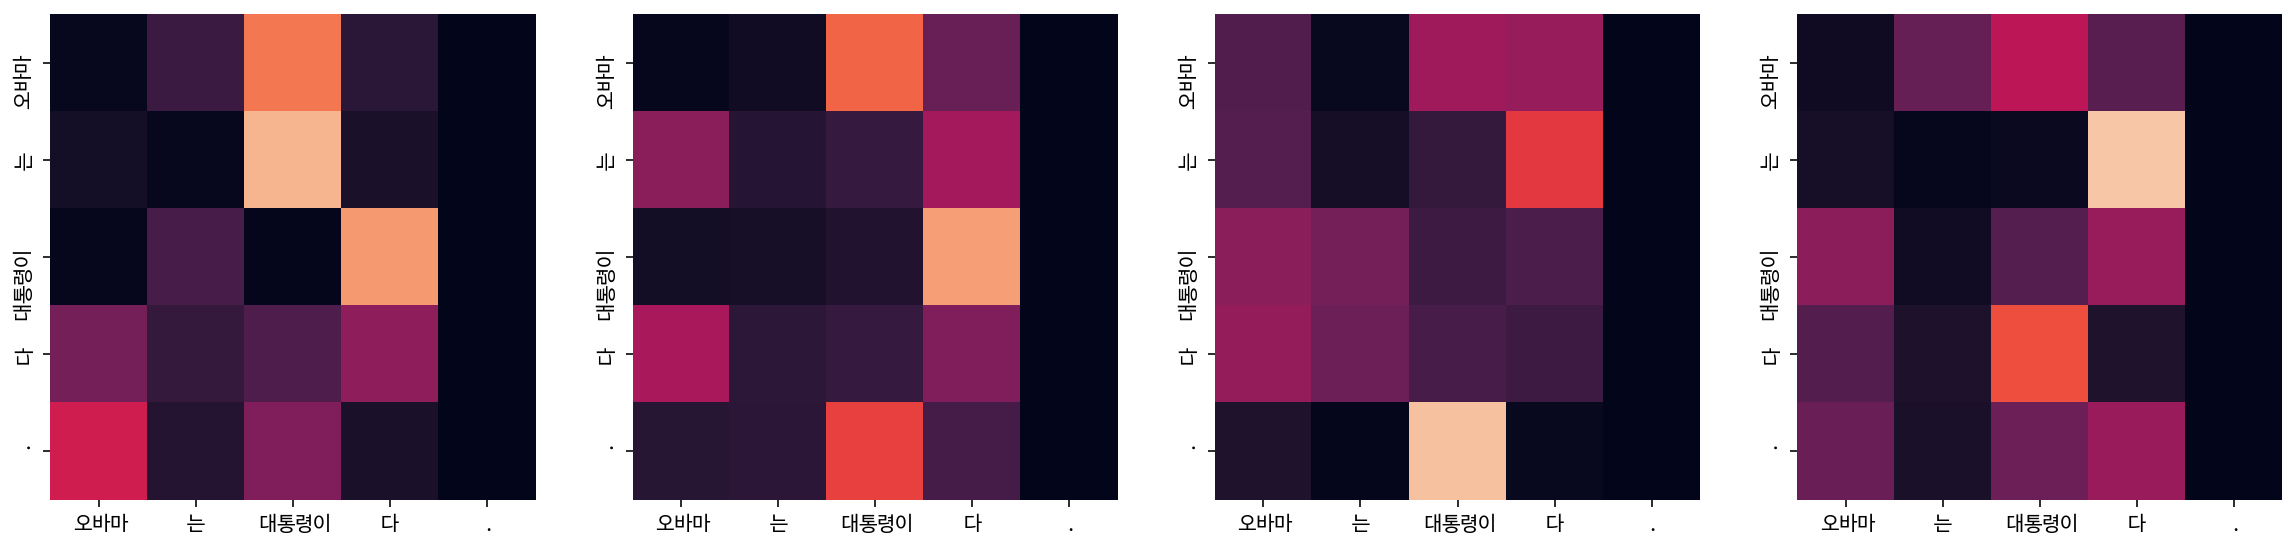

Encoder Layer 2


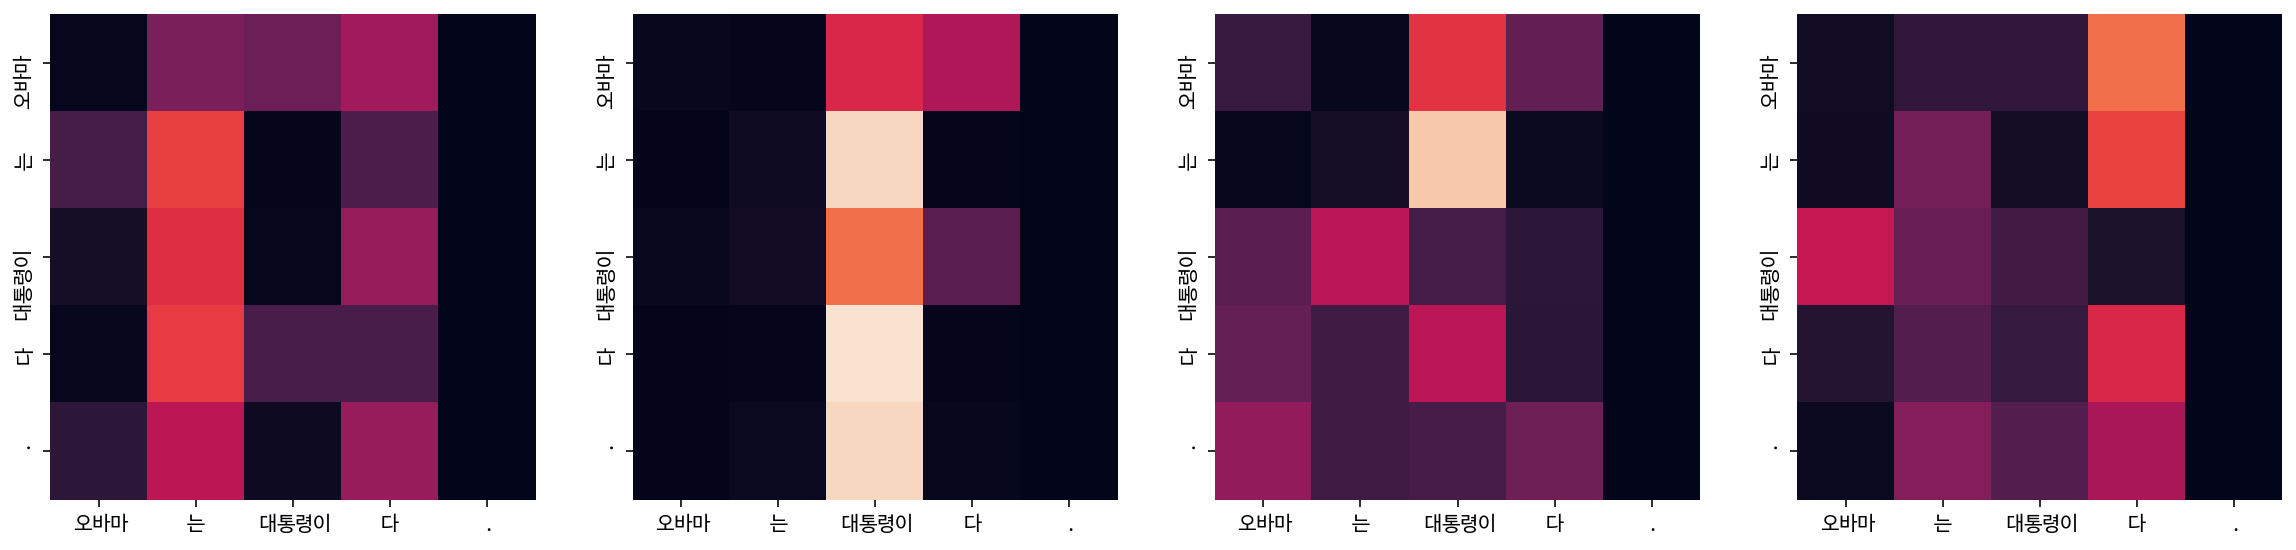

Decoder Self Layer 1


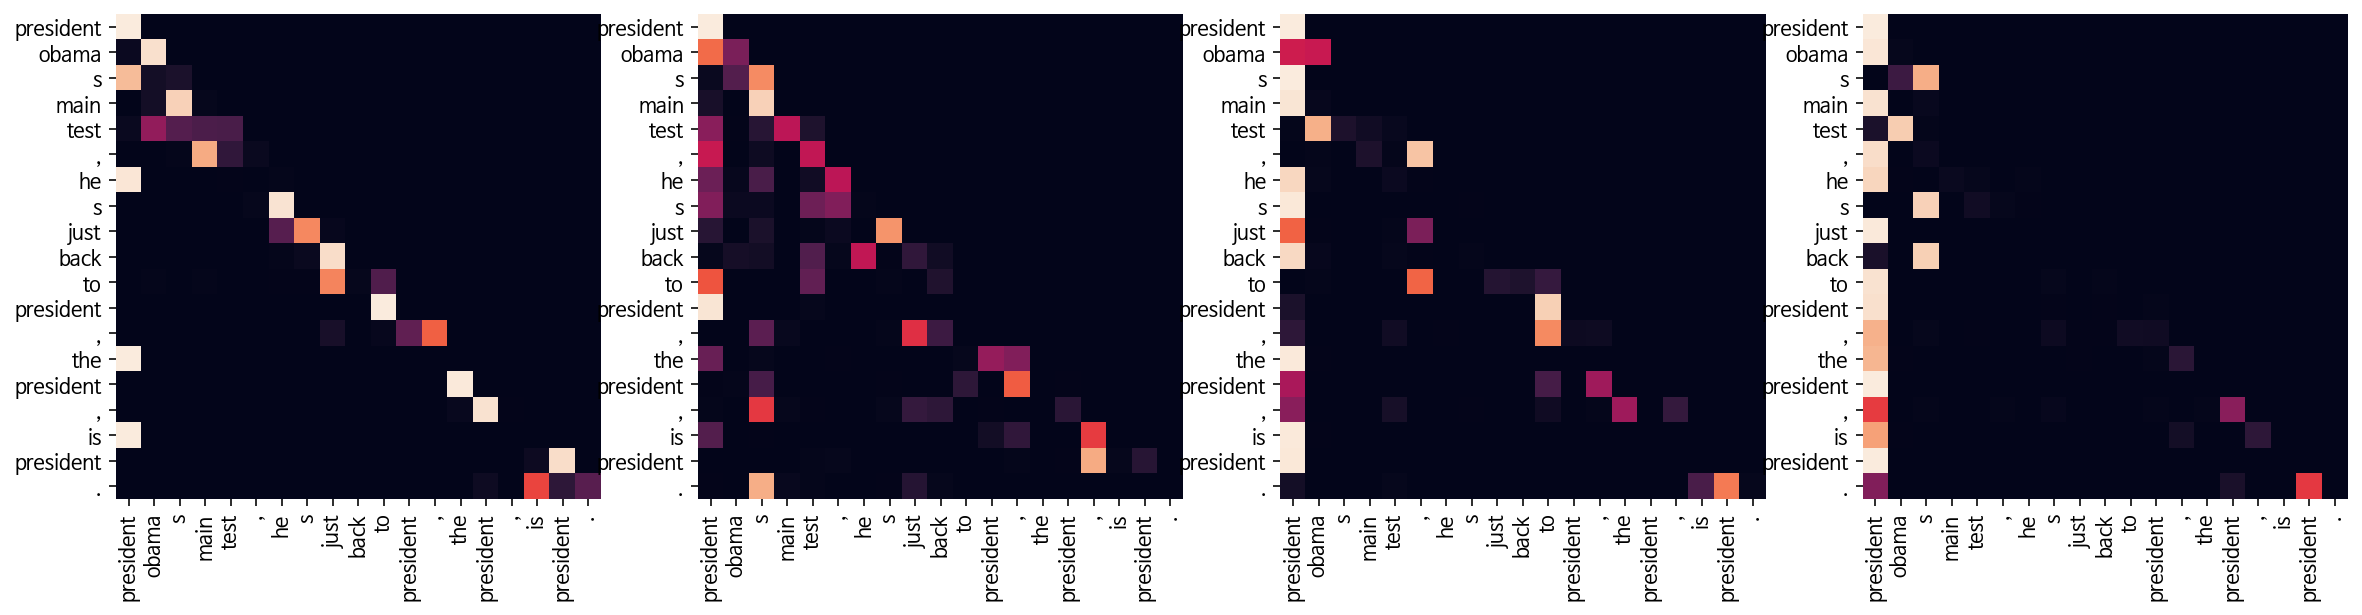

Decoder Src Layer 1


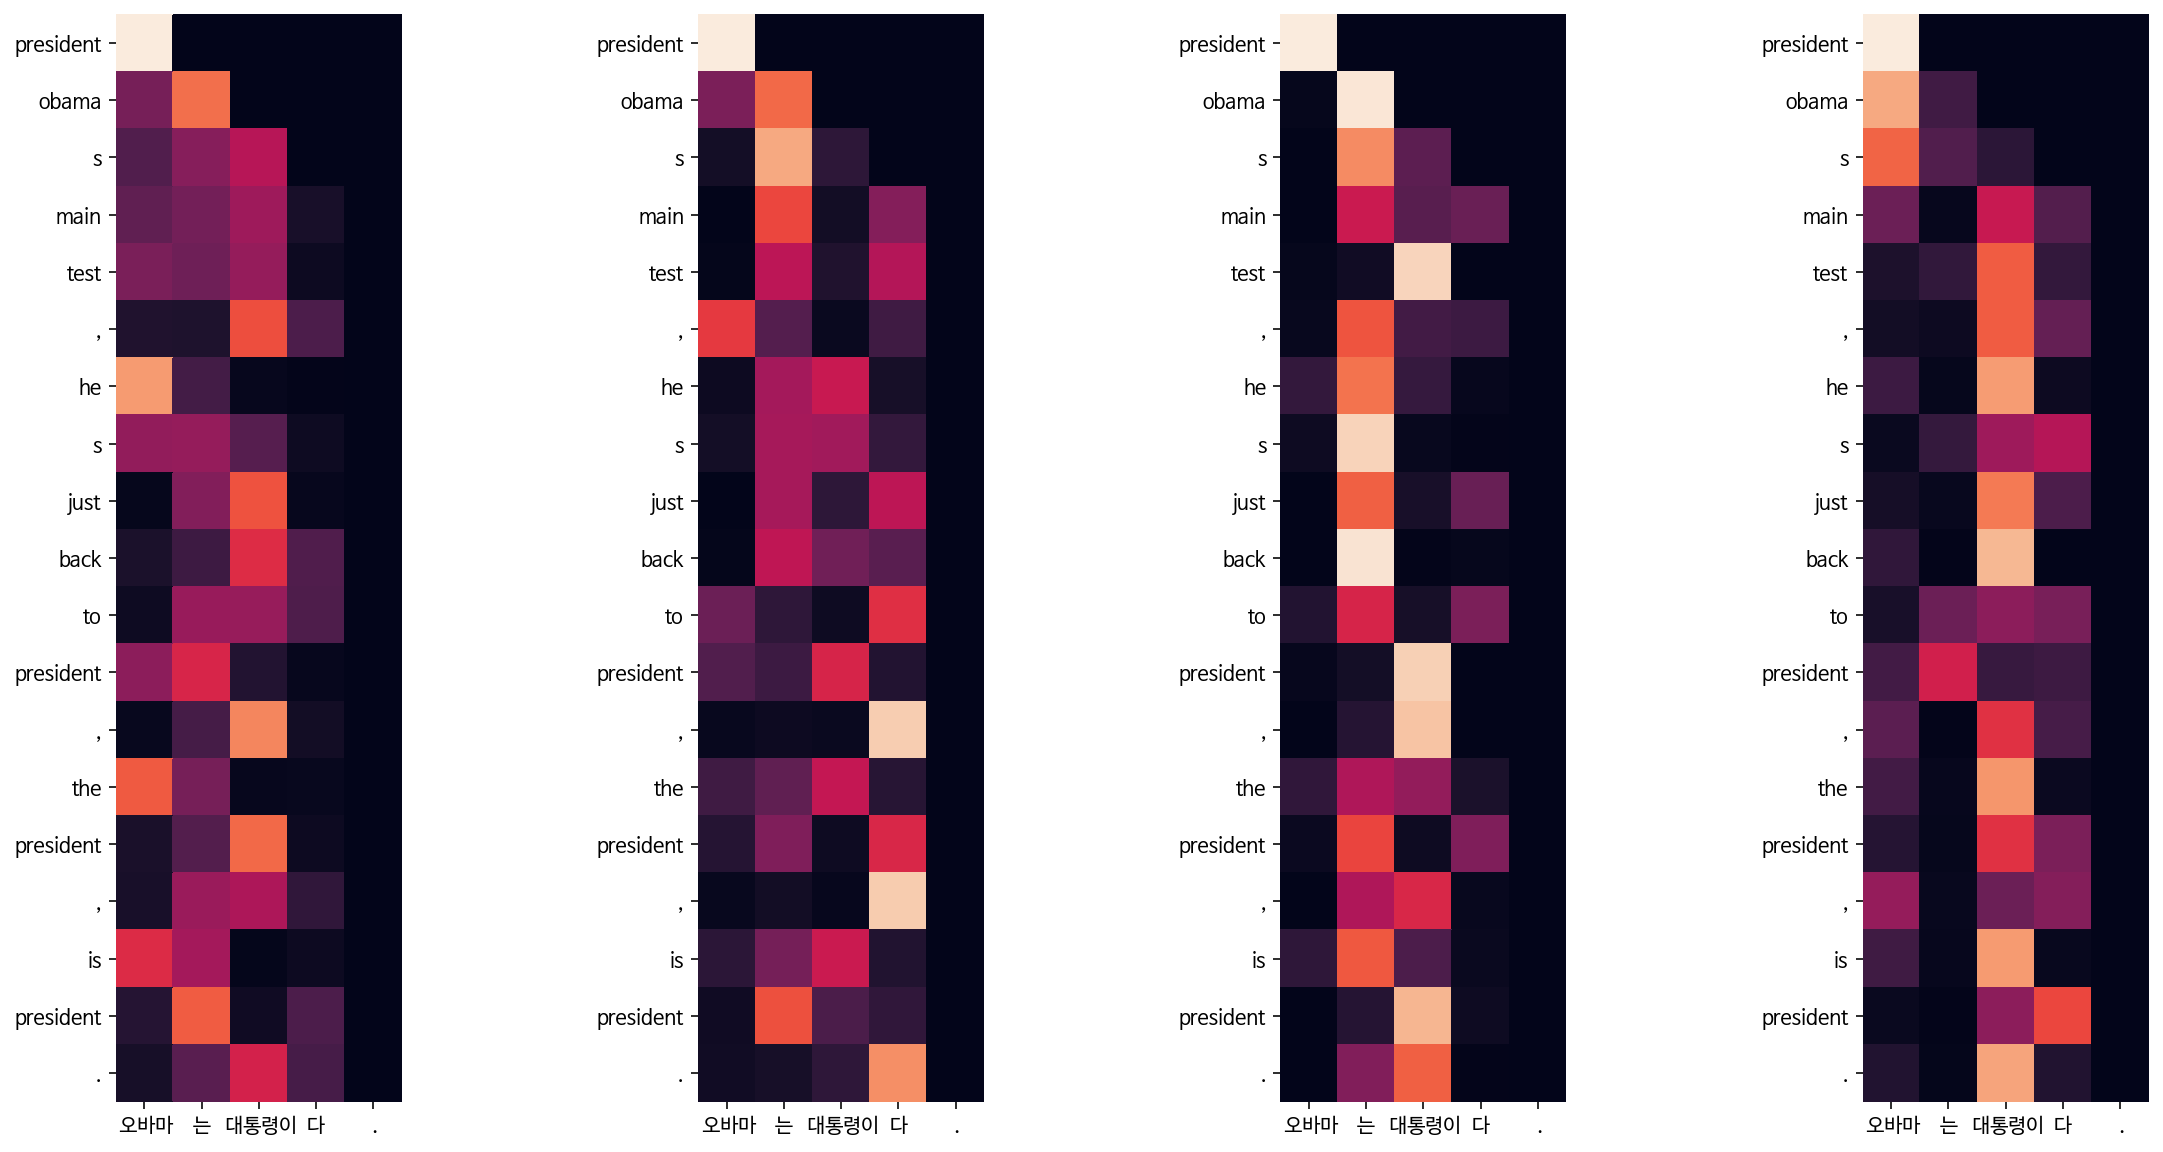

Decoder Self Layer 2


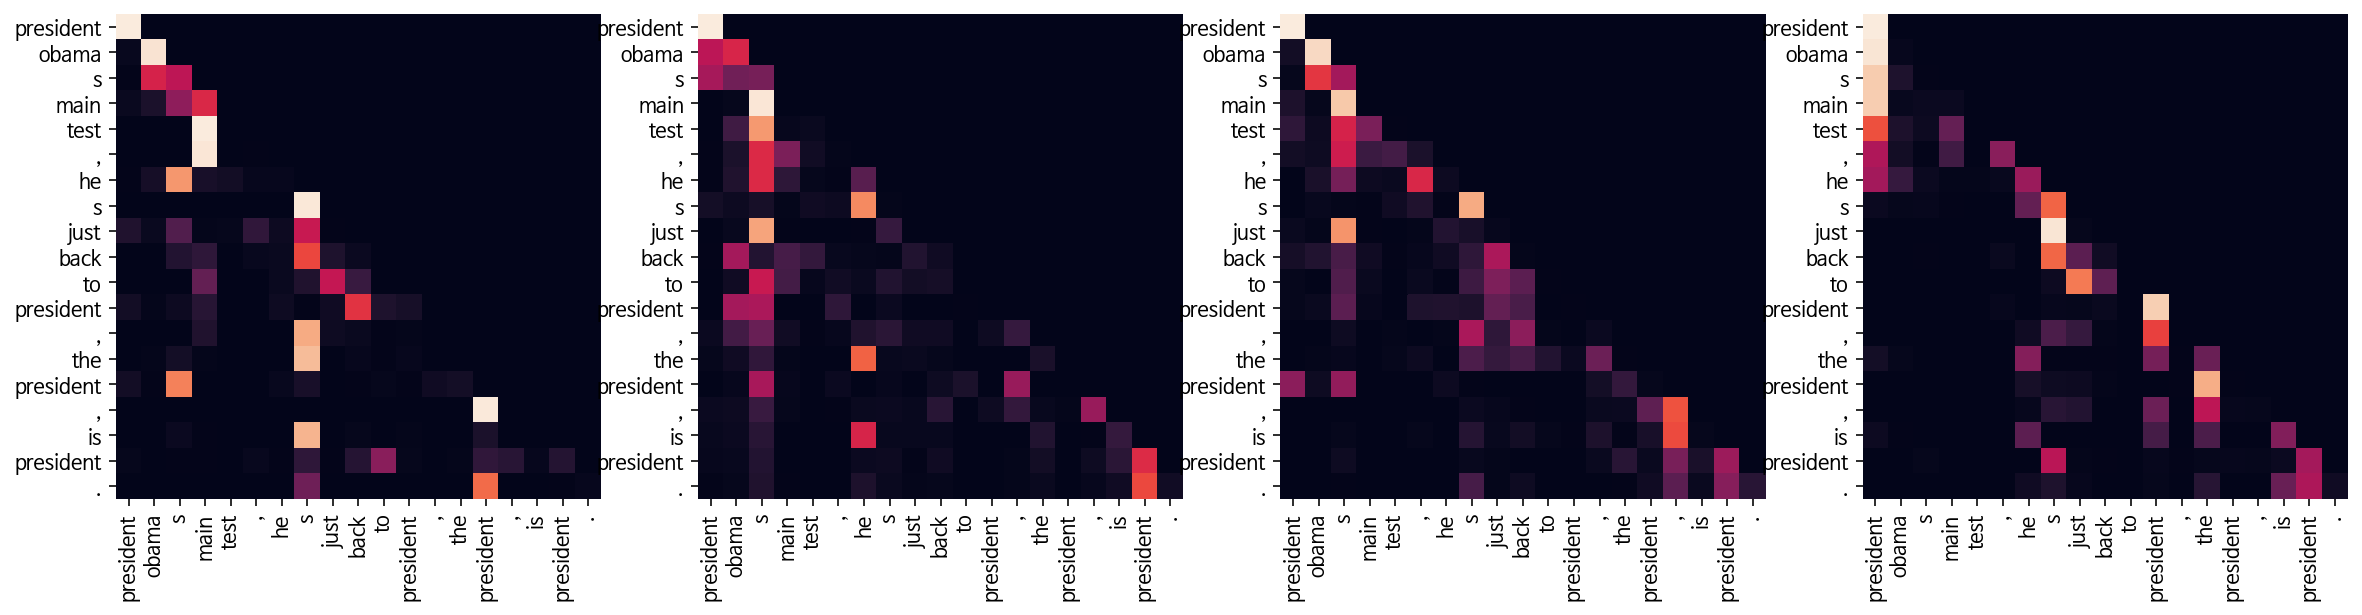

Decoder Src Layer 2


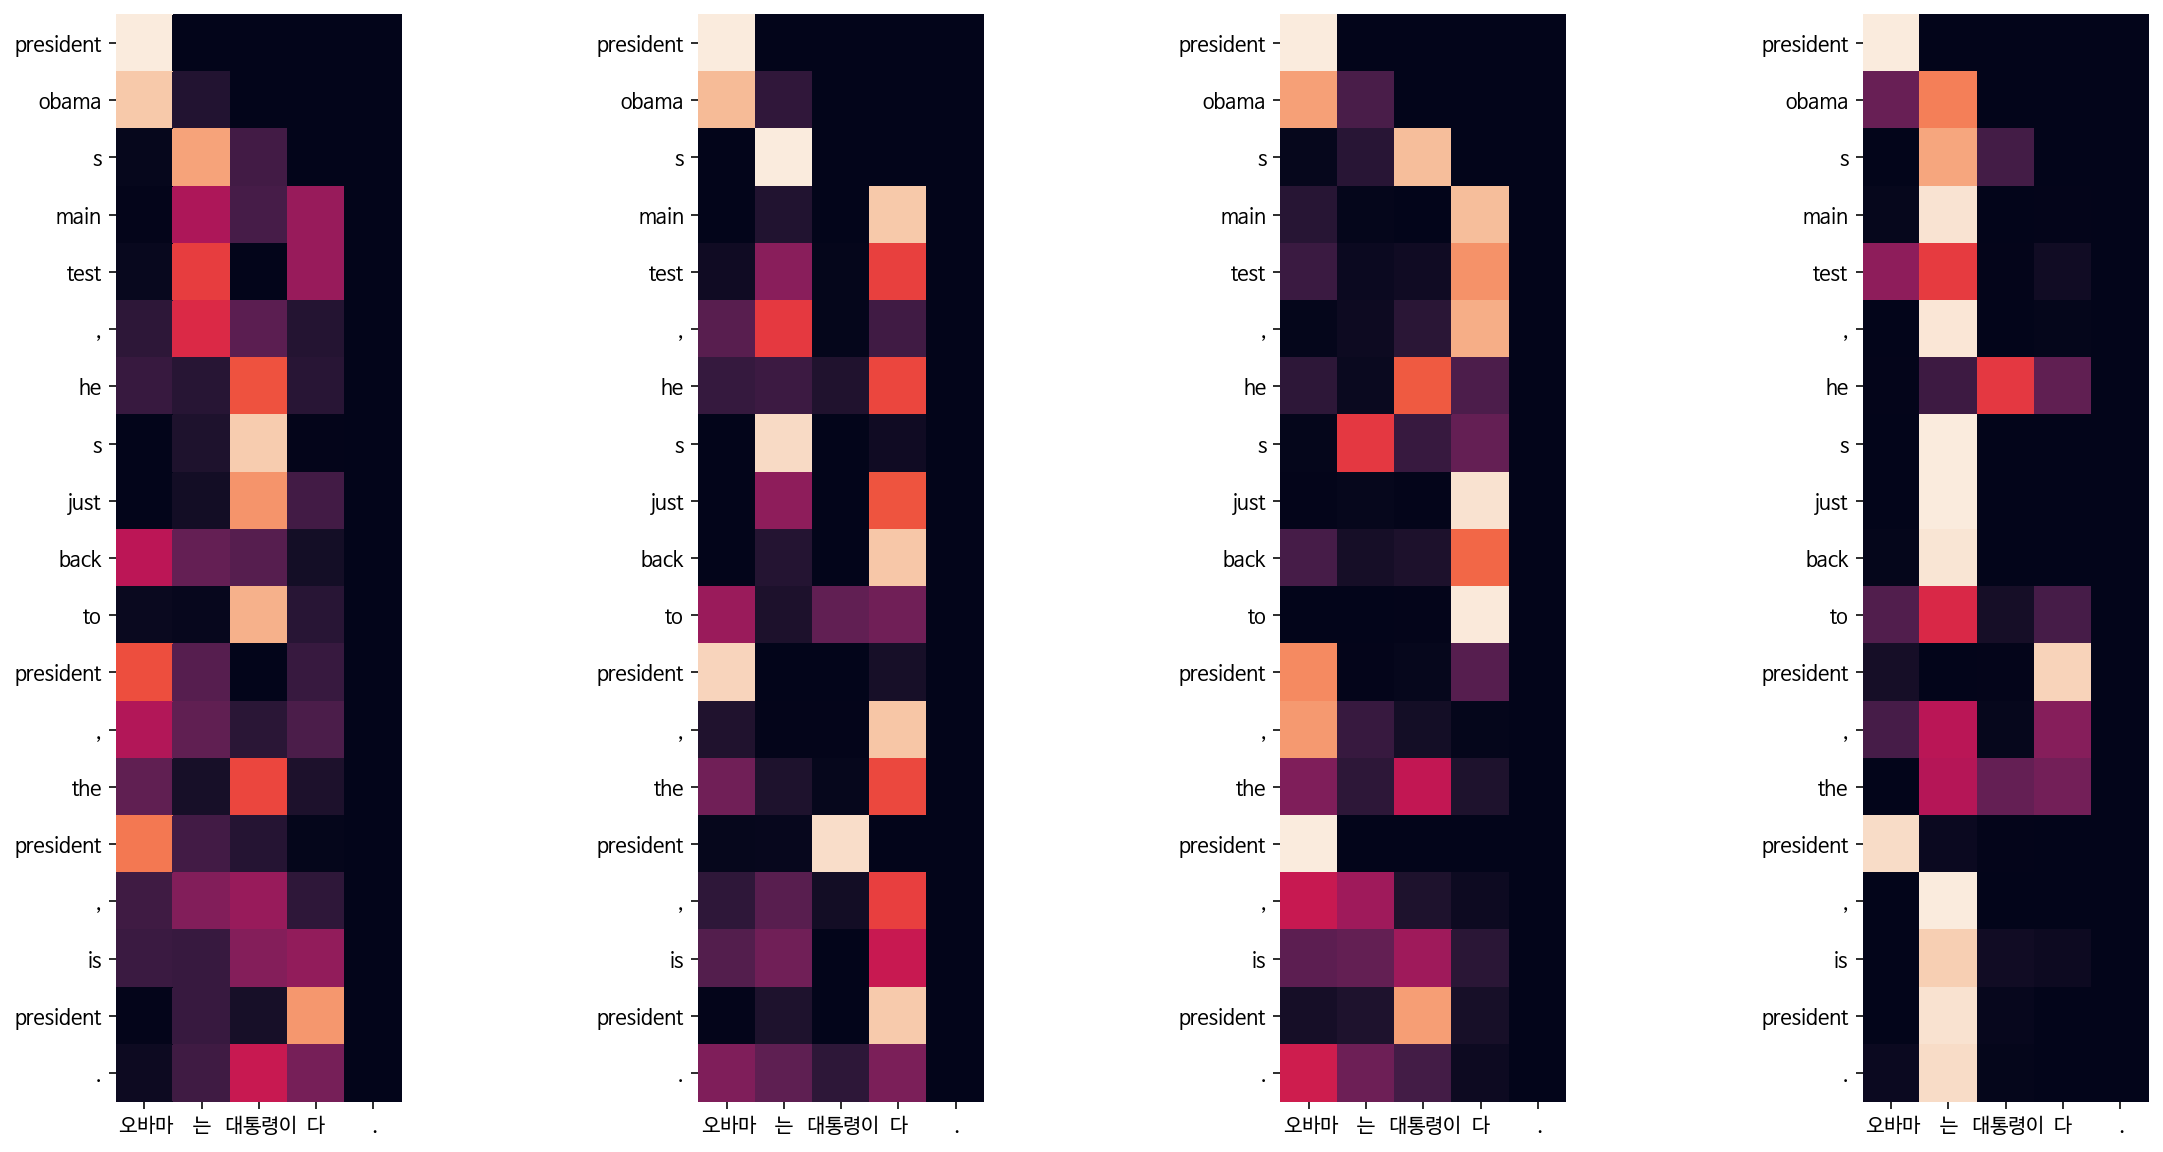

In [37]:
translate('오바마는 대통령이다.', transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

Input: 커피는 필요 없다.
Predicted translation: don t need to need short need to need .
Encoder Layer 1


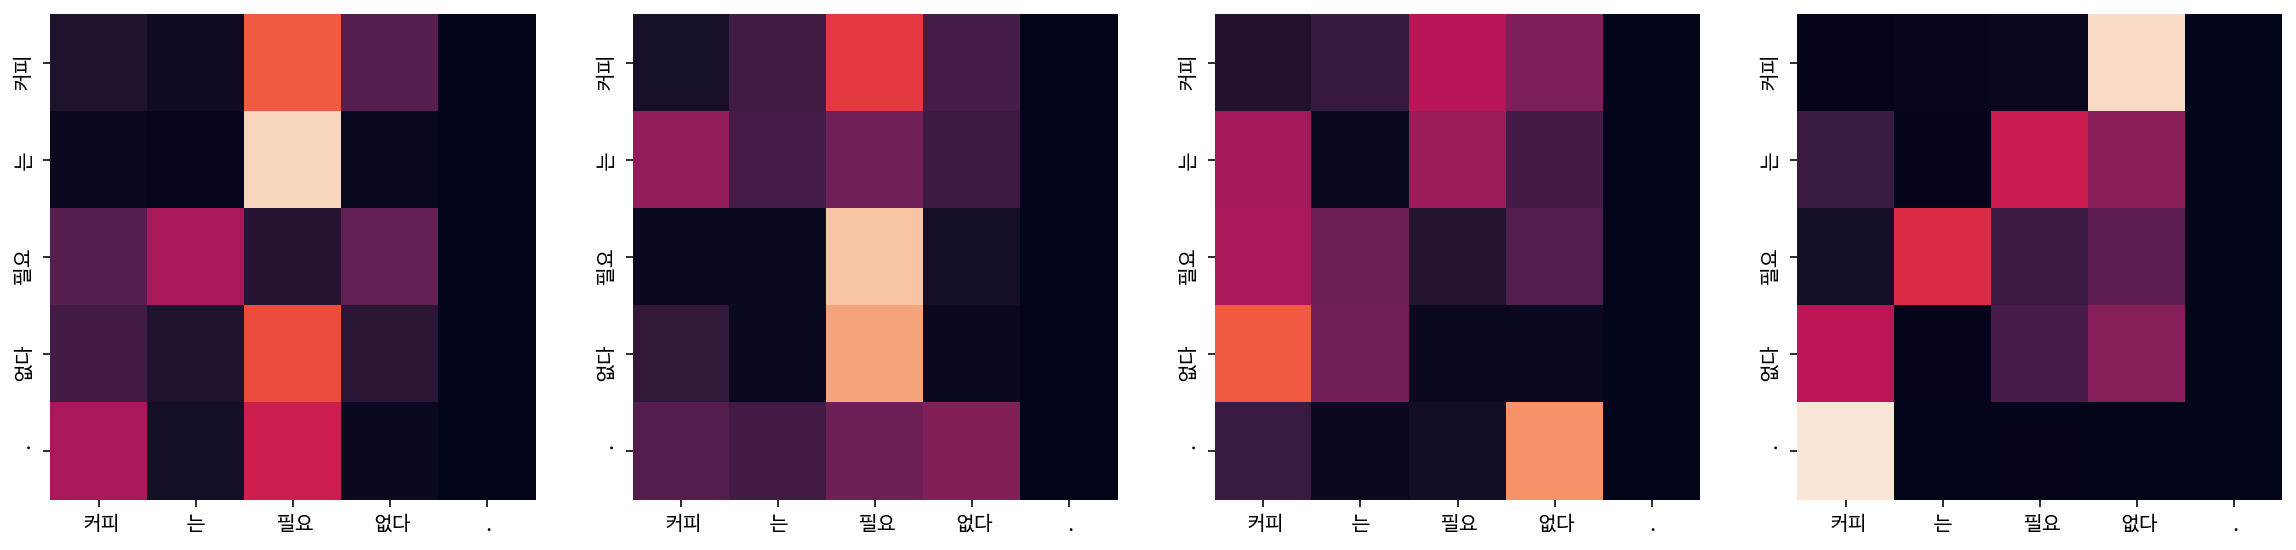

Encoder Layer 2


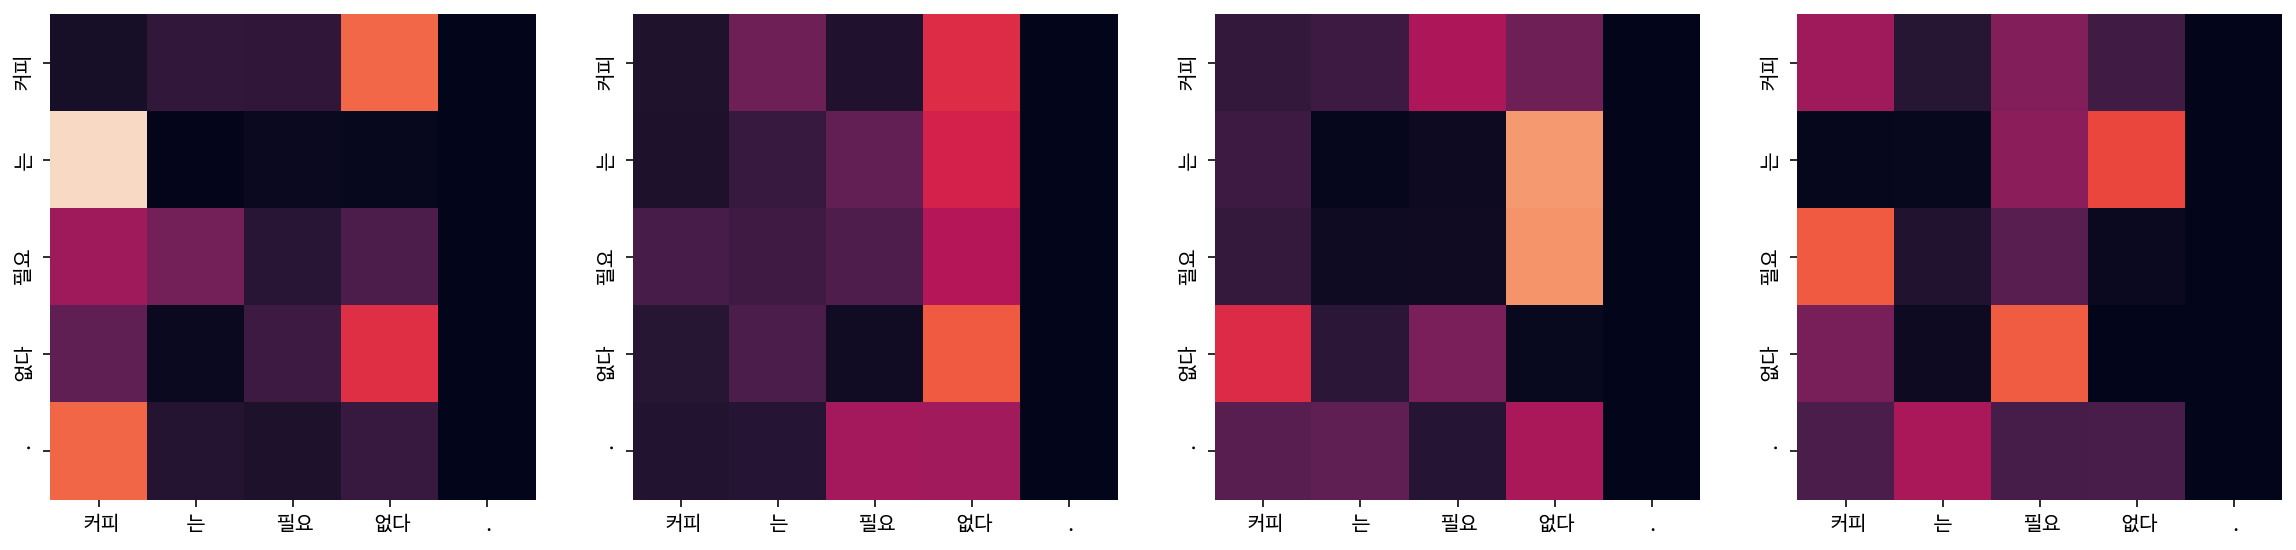

Decoder Self Layer 1


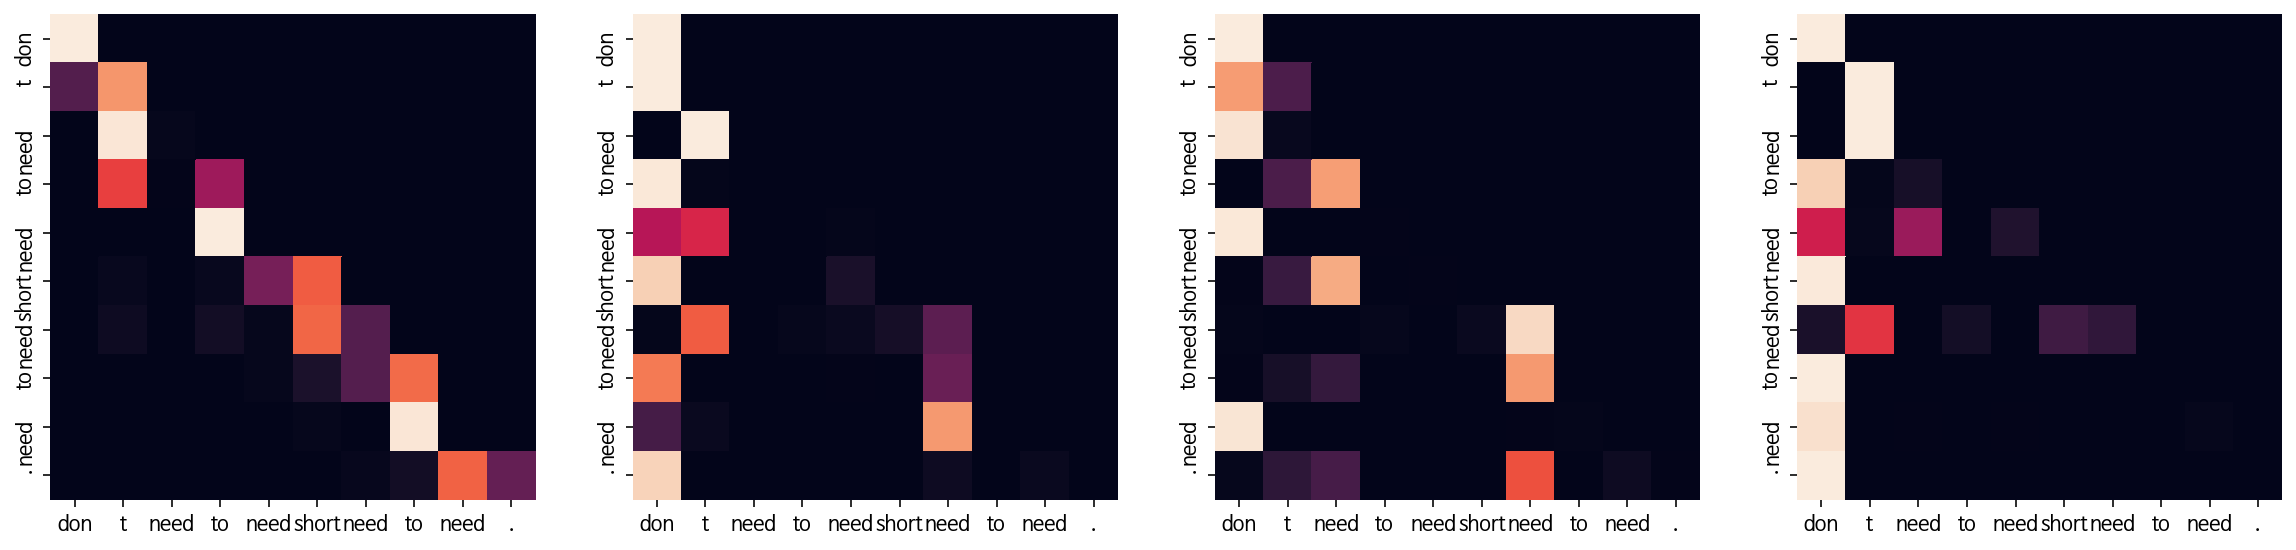

Decoder Src Layer 1


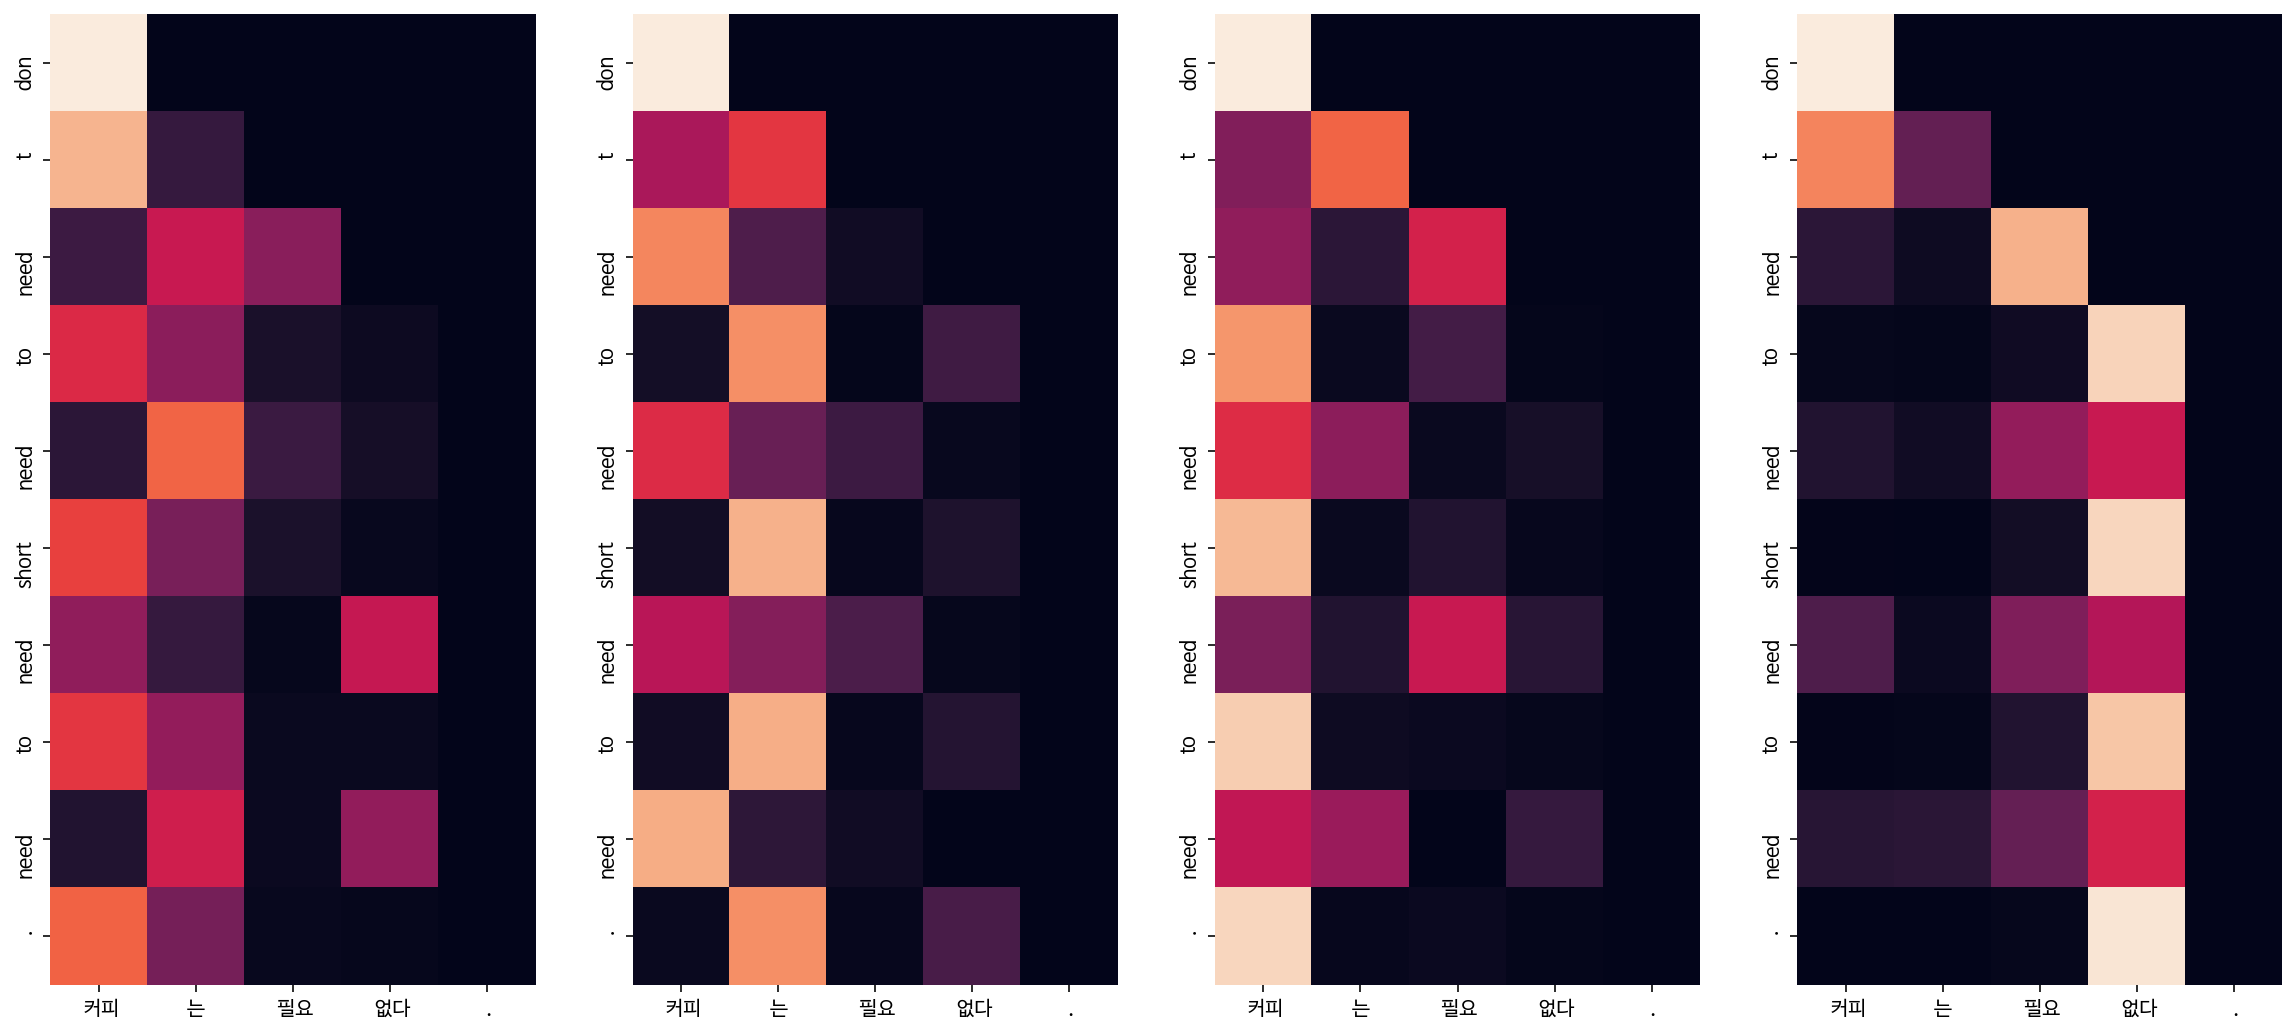

Decoder Self Layer 2


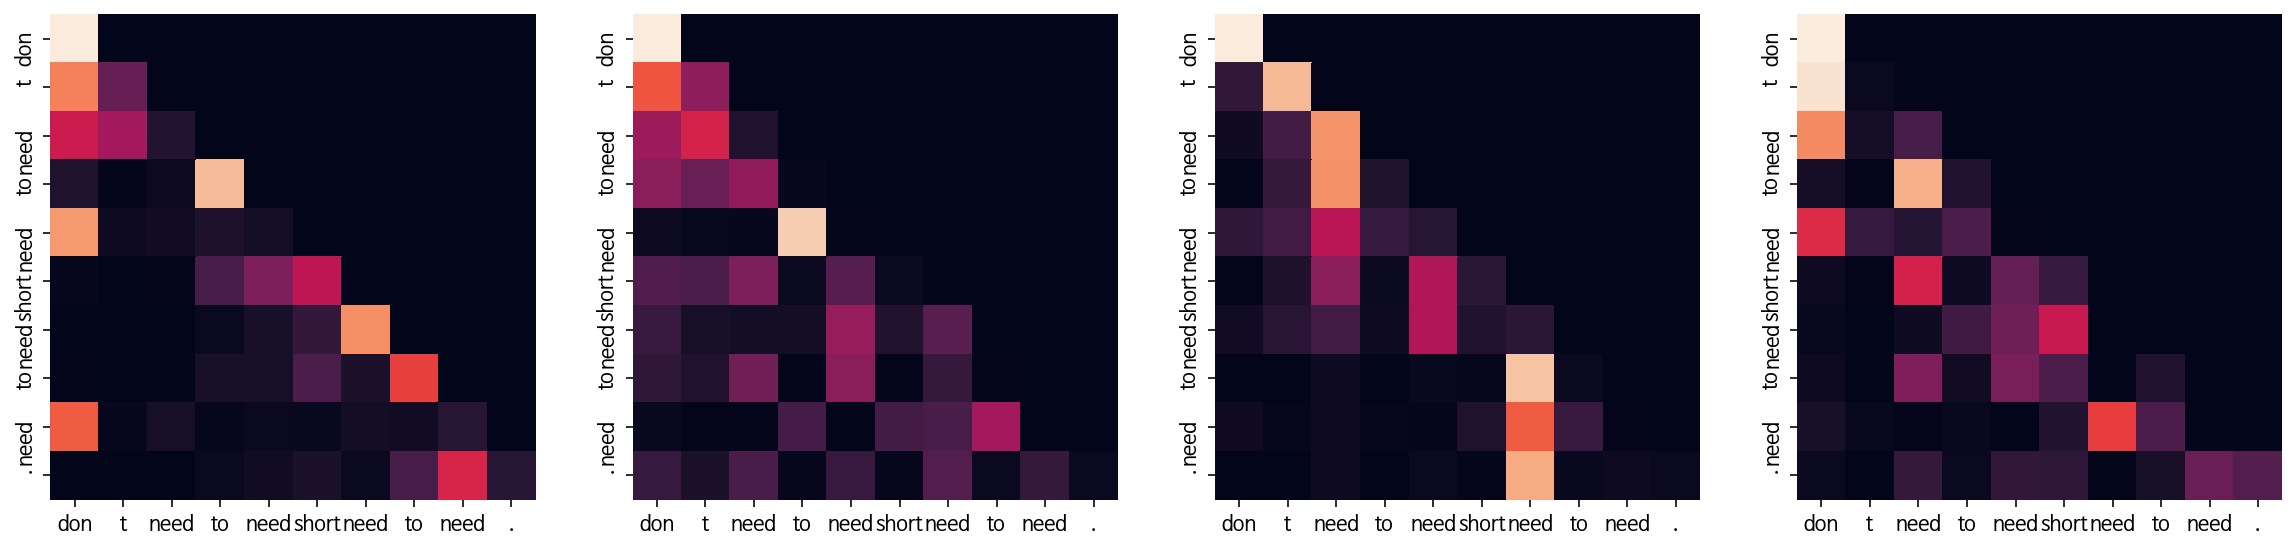

Decoder Src Layer 2


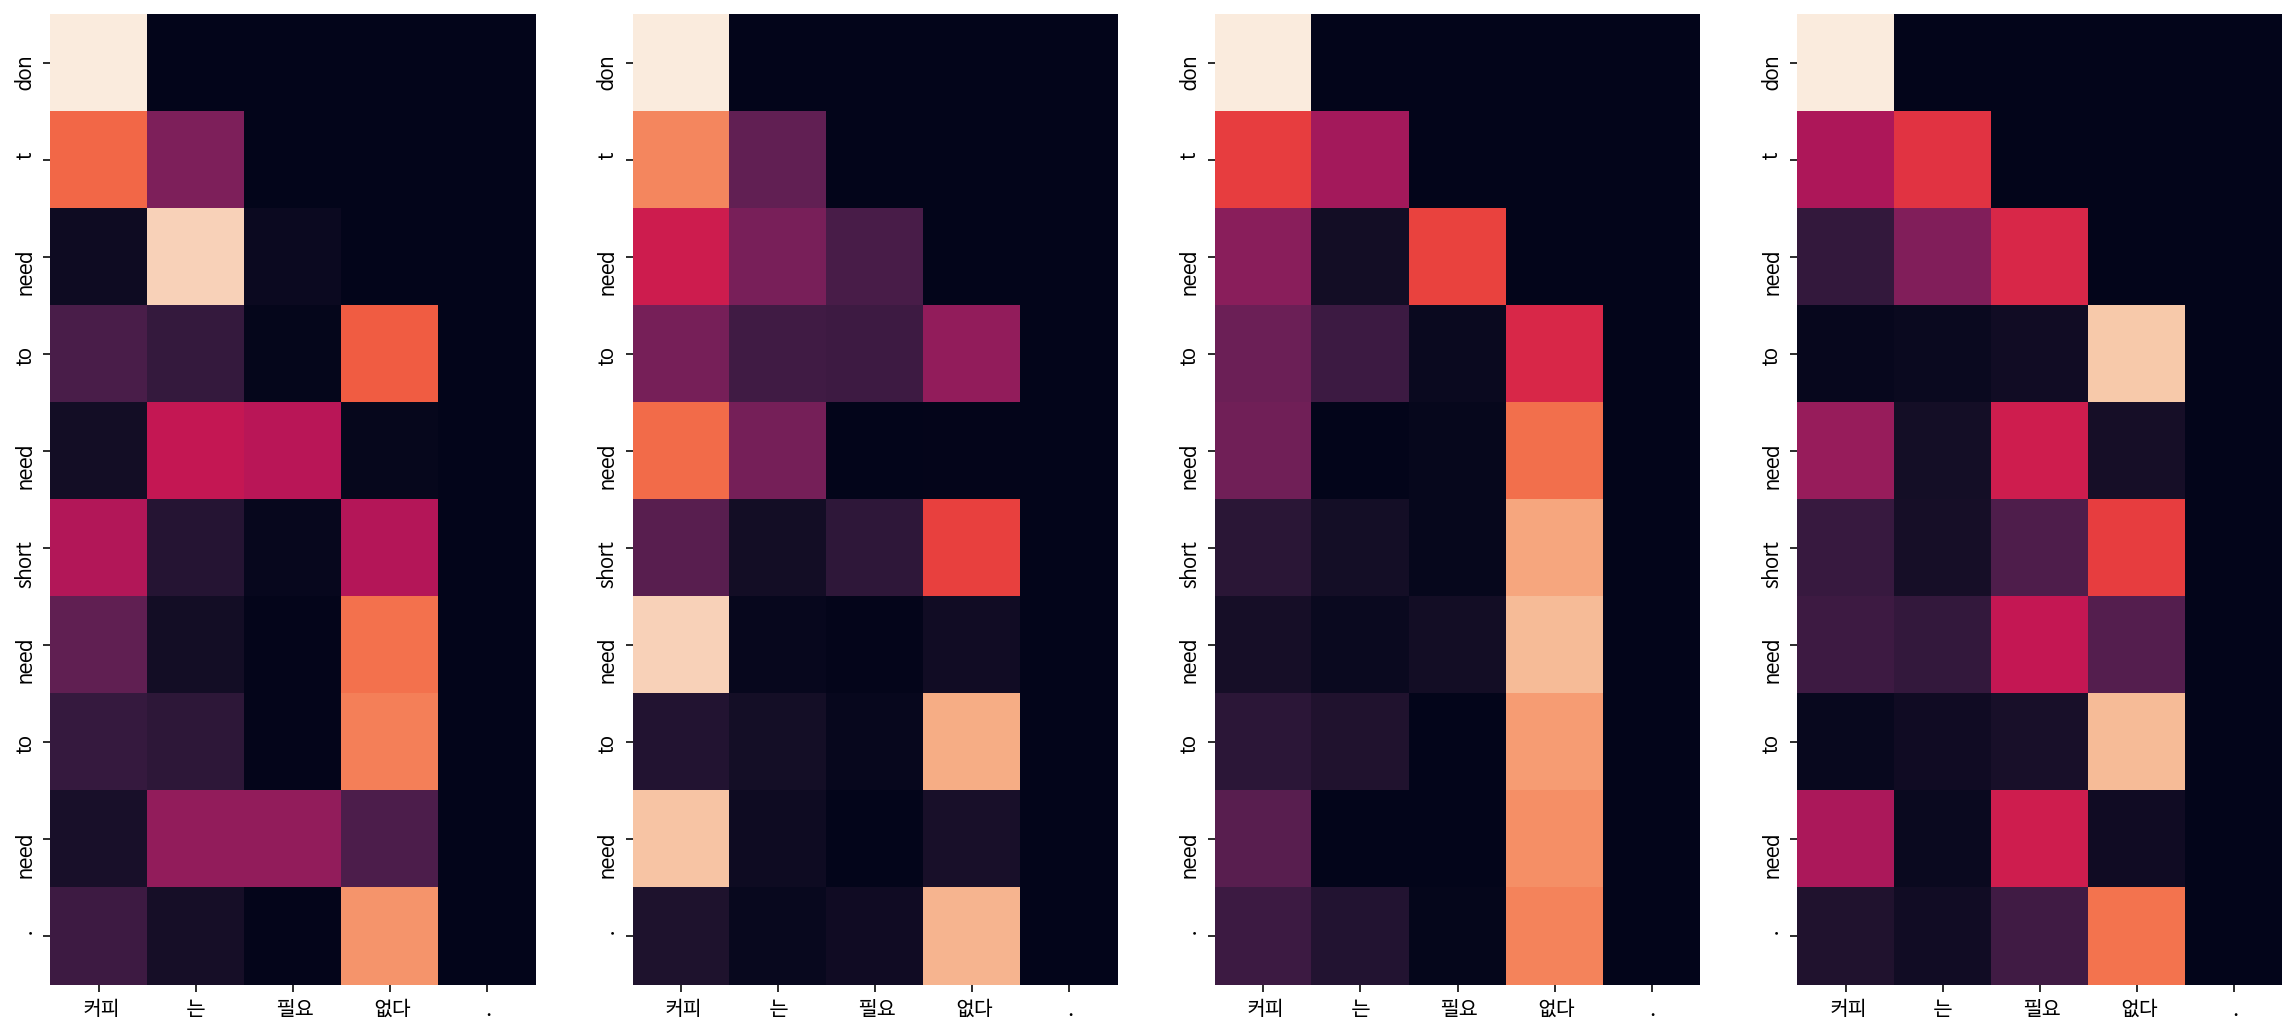

In [38]:
translate('커피는 필요 없다.', transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

### 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

|평가문항|	상세기준||
|:------:|:--------:|:--------:|
|1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.|데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.|Y|
|2. Transformer 번역기 모델이 정상적으로 구동된다.|Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.|Y|
|3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.|제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.| ?|


## 후기
### 이번 프로젝트에서 어려웠던 점
- 트랜스포머 구현 코드 이해

### 프로젝트를 진행하면서 알게된 점
- 트랜스포머의 구조
- 트랜스포머의 구현 코드 

### 프로젝트를 진행하면서 아직 모호한 점
- 매번 봐도 새롭게 느껴지는 트랜스포머와 코드


### 자기 다짐
이번 프로젝트는 다음 노드의 내용과 겹치는 부분이 많아서 어렵지 않게 해결할 수 있었다. 그렇지만 매번 봐도 트랜스포머는 새롭다. 그래도 이전에 프로젝트를 해본 적이 있어서 익숙했던 것 같다. 

학습 진행 후 결과가 그렇게 좋지 않다. epoch를 늘리니 더 안 좋은 결과가 나왔다. seq2seq보다는 좋은 결과가 나왔지만 기대만큼은 아니었다. 그렇지만 더 많은 데이터와 큰 모델로 돌리는 번역기도 제대로 된 결과를 내지 않을 때가 있다는 것을 생각하면 NLP 모델이 가야할 길이 아직 멀은 것 같다. 